# Invertible Iterative Neural Networks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#%matplotlib widget

from sklearn.metrics import confusion_matrix
import seaborn as sns

import json
#import wandb
import os

import sys
from iterativenn.iterativenn.src.iterativenn import utils
from iterativenn.iterativenn.src.iterativenn.nn_modules.MaskedLinear import MaskedLinear
#sys.path.append("iterativenn/iterativenn/src/iterativenn/nn_modules/")

#from /iterativenn/iterativenn/src/iterativenn/nn_modules import MaskedLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## W and B setup WIP

In [ ]:
#os.environ['WANDB_API_KEY'] = '57680a36aa570ba8df25adbdd143df3d0bf6b6e8'
#config = {
#    'wandb_entity': 'kjmetzler',
#    'wandb_project': 'DTRA_kjm',
#}
# 
#os.environ['WANDB_NOTEBOOK_NAME'] = '/home/kjmetzler/iterativenn/notebooks/START_HERE/4f-kjm-Chemical-Classification.ipynb'#
#
#def run_with_wandb(config, **kwargs):
#    config.update(kwargs)
# 
#    wandb.init(entity=config['wandb_entity'],
#               project=config['wandb_project'],
#               config=config,
#               settings=wandb.Settings(start_method="fork"))
# 
#    # Set the number of threads
#    torch.set_num_threads(1)
# 
#    # Find out is there is a GPU available
#    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#    if not config['gpu']:
#        device = torch.device('cpu')
#    print(f'Using device: {device}')

In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from datetime import datetime
import time


start_time = time.time()

def elapsed_time():
    return time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))

def print_with_timestamp(message):
    print(f"{elapsed_time()}: {message}", flush=True)

print_with_timestamp("Loading data...")
cate_data = pd.read_feather('/home/kjmetzler/synthetic_train_spectra_subset.feather')
kevin_data = pd.read_csv('/home/kjmetzler/generated_synthetic_data.csv')
testing = pd.read_feather('/home/kjmetzler/test_data_subset.feather')
real_data = pd.read_feather('/home/kjmetzler/train_data_subset.feather')

# One-hot encoding
def one_hot_encode(df, label_col):
    one_hot_labels = pd.get_dummies(df[label_col]).astype(int)
    df.drop(label_col, axis=1, inplace=True)
    return df, one_hot_labels

print_with_timestamp("One-hot encoding test data...")
cate_data, cate_one_hot_labels = one_hot_encode(cate_data, 'Label')
cate_data = pd.concat([cate_data, cate_one_hot_labels], axis=1)

kevin_data, kevin_one_hot_labels = one_hot_encode(kevin_data, 'Label')
kevin_data = pd.concat([kevin_data, kevin_one_hot_labels], axis=1)
kevin_data = kevin_data.drop(columns=['1684','1683','1682','1681','1680','1679','1678','1677','1676'], axis=1)
# Rename the last 8 columns to the specified names
kevin_data.rename(columns={kevin_data.columns[-8]: 'DEB', 
                           kevin_data.columns[-7]: 'DEM', 
                           kevin_data.columns[-6]: 'DMMP', 
                           kevin_data.columns[-5]: 'DPM', 
                           kevin_data.columns[-4]: 'DtBP', 
                           kevin_data.columns[-3]: 'JP8', 
                           kevin_data.columns[-2]: 'MES', 
                           kevin_data.columns[-1]: 'TEPO'}, inplace=True)

testing = testing.drop(columns=['Unnamed: 0', 'index', 'Label'], axis=1)
real_data = real_data.drop(columns=['Unnamed: 0', 'index', 'Label'], axis=1)

label_size = cate_one_hot_labels.shape[1]
data_size = real_data.shape[1] - label_size


print(cate_data.shape)
print(kevin_data.shape)
print(testing.shape)
print(real_data.shape)

00:00:00: Loading data...
00:00:16: One-hot encoding test data...
(8000, 1684)
(80000, 1684)
(8000, 1684)
(8000, 1684)


## Importing Data

In [6]:
# Intake the mass spec data csv
train = pd.read_feather('/home/kjmetzler/train_data_subset.feather')
test = pd.read_feather('/home/kjmetzler/test_data_subset.feather')
# df = pd.read_csv('/home/kjmetzler/iterativenn/notebooks/START_HERE/4-data/mass_spec_data(in).csv',header=0)

# Function to sample 50 instances per class
def sample_per_class(df, label_col, n_samples=50):
    sampled_df = df.groupby(label_col).apply(lambda x: x.sample(n=min(len(x), n_samples), random_state=42)).reset_index(drop=True)
    return sampled_df

# Sample 50 instances per class from the train and test datasets
df = sample_per_class(train, 'Label', 50)
testing = test

# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(df['Label'], prefix='Label').astype(int)  # Convert to 1/0

# Drop the original 'Label' column and concatenate the one-hot encoded labels
df = df.drop('Label', axis=1)
df = df.drop('Unnamed: 0', axis=1)
df = df.drop("index", axis=1)
#df = pd.concat([df, one_hot_labels], axis=1)

one_hot_labels = pd.get_dummies(testing['Label'], prefix='Label').astype(int)  # Convert to 1/0

# Drop the original 'Label' column and concatenate the one-hot encoded labels
testing = testing.drop('Label', axis=1)
testing = testing.drop('Unnamed: 0', axis=1)
testing = testing.drop("index", axis=1)
#testing = pd.concat([testing, one_hot_labels], axis=1)

print(df.iloc[0:5,:])

label_size = one_hot_labels.shape[1]
data_size = df.shape[1] - label_size
total_size = df.shape[1]
total_rows = df.shape[0]


   p_184  p_185  p_186  p_187  p_188  p_189  p_190  p_191  p_192  p_193  ...  \
0   89.0   92.0   96.0   99.0  104.0  110.0  114.0  118.0  123.0  127.0  ...   
1  105.0  107.0  111.0  115.0  119.0  124.0  131.0  136.0  142.0  145.0  ...   
2  106.0  110.0  114.0  118.0  122.0  130.0  137.0  144.0  150.0  159.0  ...   
3  100.0  104.0  109.0  114.0  120.0  125.0  130.0  135.0  141.0  147.0  ...   
4  114.0  119.0  126.0  131.0  135.0  142.0  148.0  154.0  162.0  168.0  ...   

   n_1020  n_1021  DEB  DEM  DMMP  DPM  DtBP  JP8  MES  TEPO  
0   -16.0   -13.0  1.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  
1   -11.0   -11.0  1.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  
2    -7.0    -7.0  1.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  
3   -19.0   -20.0  1.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  
4    -5.0    -4.0  1.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  

[5 rows x 1684 columns]


## Noise Function 

In [7]:
def add_noise(dataframe, n=1):
    labels = dataframe.iloc[:, -one_hot_labels.shape[1]:]  # Last 50 columns (label data)
    chemicals = dataframe.iloc[:, 0:data_size]  # Other columns (chemical data)
    
    all_blurred_chemicals = []
    
    for i in range(n):  # Apply blur n times
        # Apply a deterministic blur to the chemicals data
        blurred_chemicals = chemicals.rolling(window=3, min_periods=1, axis=1).mean().values
        blurred_chemicals = np.clip(blurred_chemicals, 0, None)  # Clipping to ensure no negative values
        
        # Scale blurred chemicals such that the largest entry is 100
        max_entry = np.max(blurred_chemicals)
        if max_entry > 0:  # Avoid division by zero
            blurred_chemicals = (blurred_chemicals / max_entry) * 100
        
        # Add a column indicating the number of times the row was blurred
        blur_count_column = np.full((blurred_chemicals.shape[0], 1), i + 1)
        blurred_chemicals_with_count = np.hstack((blurred_chemicals, blur_count_column))
        
        all_blurred_chemicals.append(blurred_chemicals_with_count)
    
    # Stack the blurred versions along the row axis
    blurred_chemicals_combined = np.vstack(all_blurred_chemicals)
    
    # Duplicate the labels to match the number of blurred chemical copies
    blurred_labels_combined = np.vstack([labels.values] * n)
    
    # Combine blurred chemicals and normalized labels
    blurred_dataframe = pd.concat([
        pd.DataFrame(blurred_chemicals_combined),
        pd.DataFrame(blurred_labels_combined)
    ], axis=1, ignore_index=True)
    
    return blurred_dataframe


### Sample Data

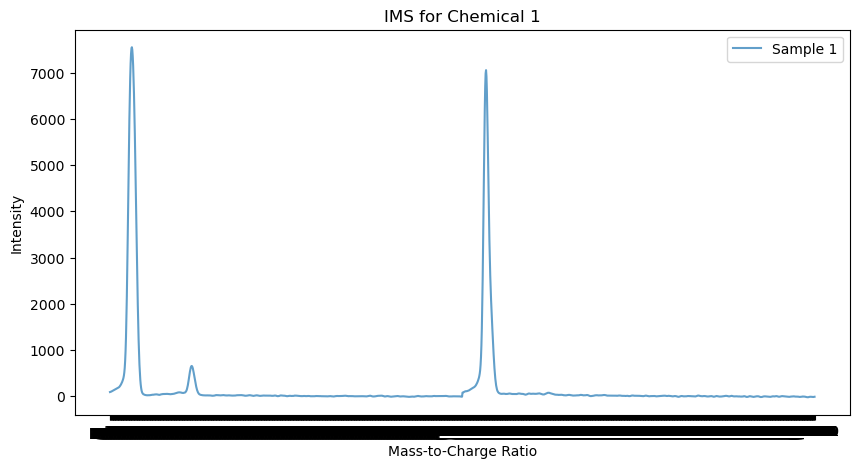

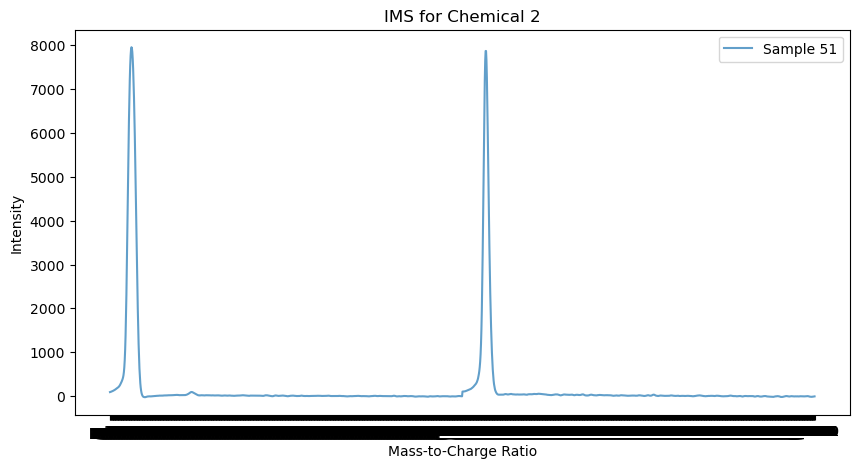

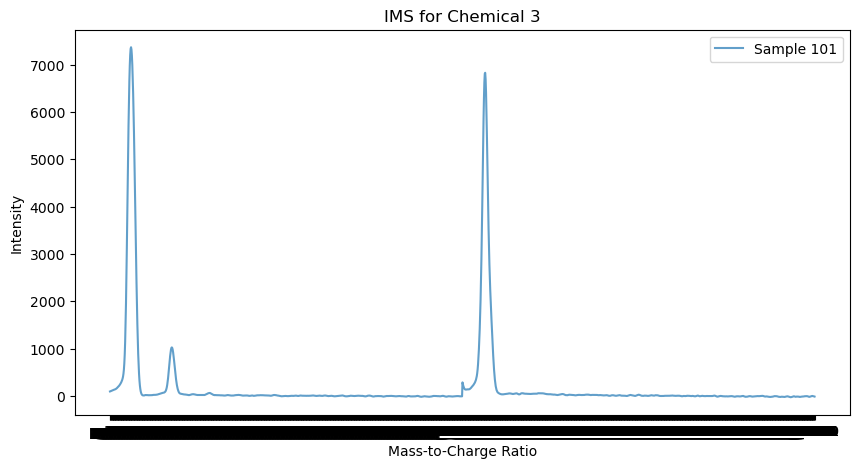

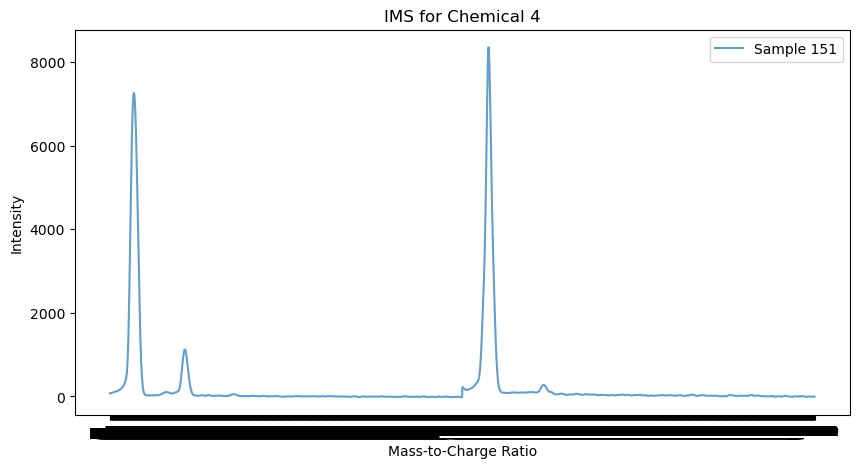

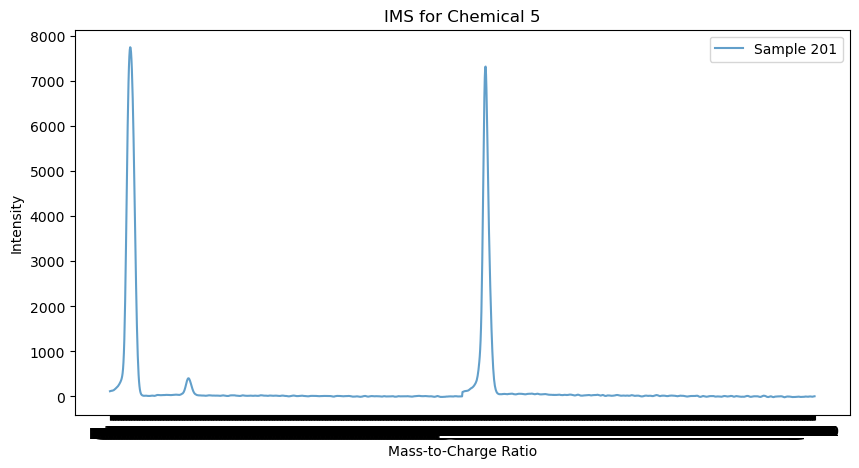

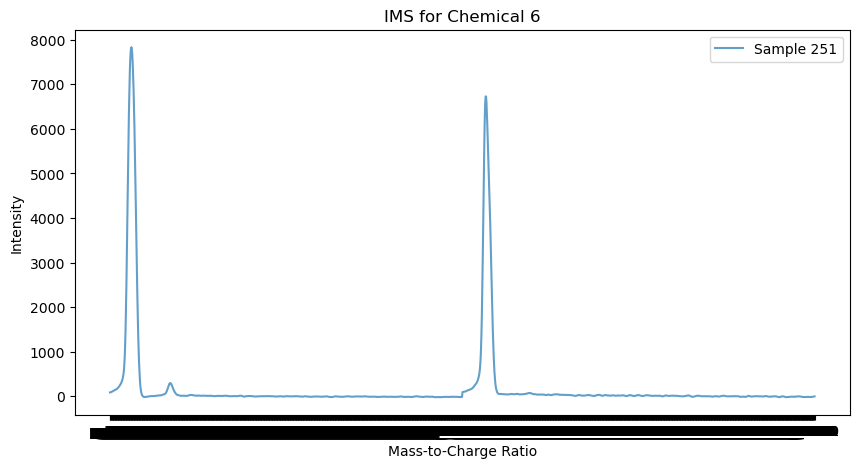

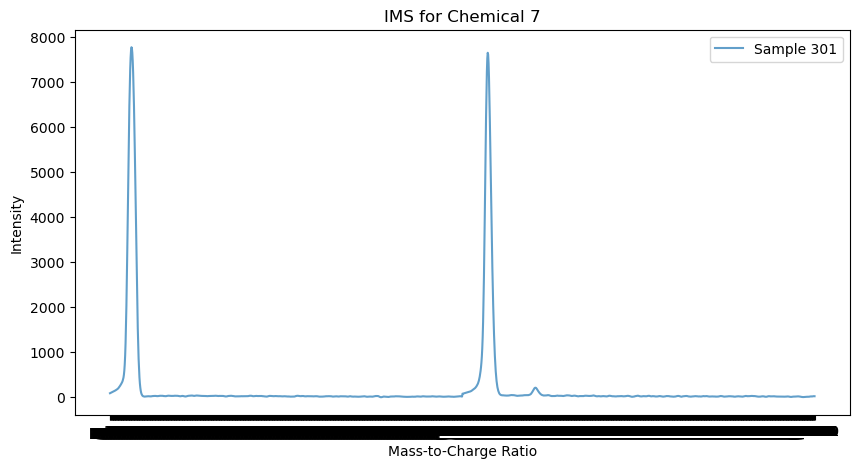

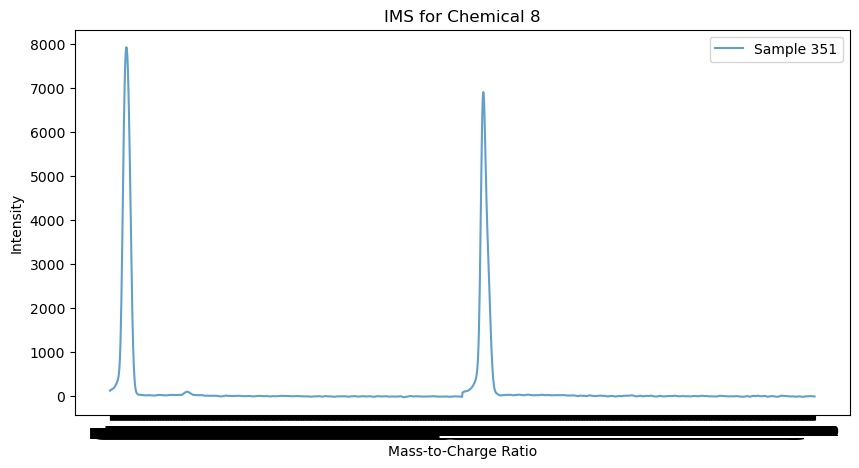

In [8]:
import matplotlib.pyplot as plt

# Extract chemical data and one-hot encoded labels
chem_sample = df.iloc[:, :data_size]  # First 915 columns (mass spec data)
labels = df.iloc[:, -label_size:]  # Last 50 columns (one-hot encoded labels)

# Iterate through each chemical class (column in one-hot labels)
for i in range(labels.shape[1]):
    # Find the index of the first row belonging to the current class
    class_rows = labels[labels.iloc[:, i] == 1].index
    if len(class_rows) == 0:  # Skip if no rows belong to this class
        continue

    first_row_idx = class_rows[0]  # Select the first example for this class
    class_name = f'Chemical {i + 1}'  # Replace with actual chemical names if available

    # Create a plot for the current class
    plt.figure(figsize=(10, 5))
    plt.plot(chem_sample.iloc[first_row_idx, :], alpha=0.7, label=f'Sample {first_row_idx + 1}')

    # Add title and labels
    plt.title(f'IMS for {class_name}')
    plt.xlabel('Mass-to-Charge Ratio')
    plt.ylabel('Intensity')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()


## Masked Linear Setup

In [9]:
# Set the size of each input vector based on the second dimension of 'x_start'.
x_size = df.shape[1]
y_size = df.shape[1]
# Determine the number of data points (rows in 'x_start').

# Define the size of blocks within the mask for each row group. 
# This is related to the 'Experimental Models' sheet in Kevin's Drive.
row_sizes = [data_size,label_size] 

# Define the size of blocks within the mask for each column group.
col_sizes = [x_size]

# Specify the types of blocks to be used in the masked linear layer. This configuration controls the structure of the weight matrix.
# 'D' indicates a diagonal block, while 
# 'W' indicates a dense block.
# 'S' indicates a sparse block, with n trainable entries distributed randomly, 'S=...'.
#  0  indicates a zero block 
block_types = [['S=10000'],['S=1000']]

# Define initialization types for the blocks.
# This dictates how the weight matrices within each block are initially set up.
# 'G' indicates a Gaussian Distribution, 1 indicates the identity, 0 indicates a zero block.
initialization_types = [[1],['G']]

# Specify which blocks are trainable.
# A value of 0 indicates the block is not trainable, while a value of 1 indicates it is trainable.
# 'non-zero' only non-zero entries are trainable
trainable = [['non-zero'],['non-zero']]

# Initialize a MaskedLinear layer with specified configurations.
chem_ml = MaskedLinear(x_size, x_size, bias=True)
chem_MaskLin = chem_ml.from_description(row_sizes=row_sizes,
                                          col_sizes=col_sizes,
                                          block_types=block_types,
                                          initialization_types=initialization_types,
                                          trainable=trainable)

# Construct the neural network using sequential layers.
# Here, 'rand_MaskLin' specifies the custom configured MaskedLinear layer, interleaved with LeakyReLU activation functions.
chem_INN = torch.nn.Sequential(chem_MaskLin, 
                               nn.LeakyReLU(0.1)).to(device)

# Number of LeakyReLU activation functions used in the network.
# This is used for determining the inverse function.
num_relus = 5


In [10]:
# How many types of noise to add
n=10

# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Generate noisy start tensor
x_start_tensor = df_to_tensor(add_noise(df,n)).to(device)

# Duplicate the target data to match the start tensor's length
df_repeated = pd.concat([df] *n, ignore_index=True)  # Duplicate dataframe 10 times
x_target_tensor = df_to_tensor(df_repeated).to(device)

# Dataset class for start and target tensors
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]

# DataLoader for training
print(x_start_tensor.shape, x_target_tensor.shape)
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)


torch.Size([4000, 1685]) torch.Size([4000, 1684])


### Sample Starting data

In [ ]:
#first_row = x_start_tensor[0].cpu().numpy()  # Convert to NumPy array

# Create a plot for the first row
#plt.figure(figsize=(10, 5))
#plt.plot(first_row, label='First Row of x_start_tensor', color='blue')

# Add title and labels
#plt.title('Noisy Spectrum for "(5R,11R)-5,11-Dimethylpentacosane"')
#plt.xlabel('Mass to Charge Ratio')
#plt.ylabel('Intensity')

# Add legend
#plt.legend()

# Display the plot
#plt.show()

In [11]:
# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss().to(device)
criterion2= torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(chem_INN.parameters(), lr=0.0001)


## Training Function

In [12]:
# Set the maximum number of epochs for training.
max_epochs = 1000
# Initialize an empty list to keep track of the loss values after each epoch.
loss_graph = []

# Begin the training loop.
#wandb_kwargs = {
#    'learning_rate': 0.0001,
##    'epochs': max_epochs,
 #   'batch_size': 100,
 #   'model_architecture': 'INN',
 #   'optimizer':'AdamW',
 #   'loss': 'MSELoss and BCELoss',
#}
 
#run_with_wandb(config, **wandb_kwargs)
 
for epoch in range(max_epochs):
    
    # Iterate over batches of data in the training loader.
    for batch_idx, (start, target) in enumerate(train_loader):
        # Reset the gradients of all model parameters to zero.
        optimizer.zero_grad()
        # Move data to the GPU
        start, target = start.to(device), target.to(device)
        
        # Pass the batch through the model to get predictions.
        set = start
        
        # Initialize the loss for the current batch.
        loss = 0
        for i in range(num_relus):
            set = chem_INN(set)
            soft_guess = set[:,-label_size:] #torch.softmax(set[:,-50:],dim=1)
            mass_spec = set[:,:data_size]
        
            
            # Calculate the loss
            loss += criterion(soft_guess, target[:,-label_size:])*20*(i+1)**2
            loss += criterion2(mass_spec, target[:,:data_size])#*(i+1)**2 

        # Compute the gradients based on this loss.
        loss.backward()
        # Update the parameters of the model according to the optimization strategy.
        optimizer.step()
        
        # Optionally, save the current state of the model.
        state = chem_INN.state_dict()
        
    # After each epoch, record the loss for plotting.
    loss_graph.append(loss.item())
    # Optionally, print the training progress every 10 epochs.
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')
        torch.cuda.empty_cache()


# After training, plot the recorded loss values.
plt.figure()
plt.plot(np.arange(0, len(loss_graph)), loss_graph)
plt.semilogy()  # Use a logarithmic scale for the y-axis to better visualize changes.
plt.show()
torch.cuda.empty_cache()
#wandb.finish()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x1685 and 1684x1684)

# Forward Results

In [ ]:
# Confusion Matrix
pred_output = chem_INN(chem_INN(chem_INN(chem_INN(chem_INN(x_start_tensor)))))
pred_last_50 = pred_output[:, -label_size:]  # Last 8 elements

target_last_50 = x_target_tensor[:,-label_size:]

pred_classes = torch.argmax(pred_last_50, dim=1).cpu().numpy()
target_classes = torch.argmax(target_last_50, dim=1).cpu().numpy()

conf_matrix = confusion_matrix(target_classes, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the plot
plt.show()

## Combinations for Test Results

In [ ]:
from sklearn.model_selection import train_test_split

def create_test_dataset(dataset, add_noise_single_row, std=0.1):
    num_features = data_size  # Number of columns for mass spec data
    num_labels = label_size     # Number of columns for labels
    print("Input to creation size: ", dataset.shape)
    # Separate features (mass spec) and labels
    mass_specs = dataset.iloc[:, :num_features]
    labels = dataset.iloc[:, num_features:]

    # Initialize lists for test and target samples
    test_samples = []
    target_samples = []

    # Set a limit for the number of combinations per class
    combination_limit = 100

    # Iterate over all pairs of samples
    for i in range(len(dataset)):
        combinations_made = 0
        for j in range(i + 1, len(dataset)):
            # Extract labels for the current pair
            label_i = labels.iloc[i]
            label_j = labels.iloc[j]

            # Check if the labels match
            if label_i.equals(label_j):
                # Add noise to the individual mass spectra
                noisy_mass_spec_i = add_noise(mass_specs.iloc[i].to_frame().T, 1).values
                noisy_mass_spec_j = add_noise(mass_specs.iloc[j].to_frame().T, 1).values

                # Compute convex combination (equal weights for simplicity)
                avg_noisy_mass_spec = (noisy_mass_spec_i[:data_size] + noisy_mass_spec_j[:data_size]) / 2
                avg_mass_spec = (mass_specs.iloc[i][:data_size] + mass_specs.iloc[j][:data_size]) / 2

                # Duplicate avg_label.values 5 times to match the rows of avg_noisy_mass_spec
                duplicated_labels = np.tile(label_i.values, (1, 1))

                # Append the generated test and target samples
                test_samples.append(np.concatenate([avg_noisy_mass_spec[:data_size], duplicated_labels], axis=1))
                target_samples.append(np.concatenate([avg_mass_spec.values[:data_size], label_i.values]))

                combinations_made += 1
                if combinations_made >= combination_limit:
                    break
                # Add noise to the individual mass spectra
                noisy_mass_spec_i = add_noise(mass_specs.iloc[i].to_frame().T,1).values#.flatten()
                noisy_mass_spec_j = add_noise(mass_specs.iloc[j].to_frame().T,1).values#.flatten()

                # Compute convex combination (equal weights for simplicity)
                avg_noisy_mass_spec = (noisy_mass_spec_i[:data_size] + noisy_mass_spec_j[:data_size]) / 2
                avg_mass_spec = (mass_specs.iloc[i][:data_size] + mass_specs.iloc[j][:data_size]) / 2

                # Duplicate avg_label.values 5 times to match the rows of avg_noisy_mass_spec
                duplicated_labels = np.tile(label_i.values, (1, 1))  # Shape becomes 5x915

                # Append the generated test and target samples
                test_samples.append(np.concatenate([avg_noisy_mass_spec[:data_size], duplicated_labels], axis=1))
                target_samples.append(np.concatenate([avg_mass_spec.values[:data_size], label_i.values]))

    # Flatten the 3D array (2397, 5, 965) to 2D (11985, 965)
    test_samples_flat = np.vstack(test_samples)  # Stack along the rows
    target_samples_repeated = np.repeat(target_samples, repeats=1, axis=0)  # Shape becomes (11985, 965)

    # Convert to DataFrames
    test_dataset = pd.DataFrame(test_samples_flat)
    target_data = pd.DataFrame(target_samples_repeated)
    print("Output size: ", test_dataset.shape)

    return test_dataset, target_data


# Example usage

# Split data into features and labels
X_train = df.iloc[:, :data_size].values  # First 915 columns (features)
y_train = df.iloc[:, -label_size:].values # Last 50 columns (one-hot encoded labels -> convert to class indices)

X_test = testing.iloc[:, :data_size].values
y_test = testing.iloc[:, -label_size:].values

# Split df into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Concatenate X_train and y_train (already one-hot encoded)
train_data = np.hstack((X_train, y_train))

# Convert to pandas DataFrame
num_features = X_train.shape[1]
columns = [f"feature_{i}" for i in range(num_features)] + [f"class_{i}" for i in range(y_train.shape[1])]
train_data_df = pd.DataFrame(train_data, columns=columns)

# Assuming `original_dataset` is your original dataset tensor of shape [num_samples, 965] (915 features + 50 labels).
# Replace `original_dataset` with your actual dataset.
# df_tensor = torch.tensor(df.values, dtype=torch.float)
test_dataset, test_target = create_test_dataset(train_data_df, add_noise, std=0.1)
test_dataset_tensor = torch.tensor(test_dataset.values, dtype=torch.float).to(device)
test_target_tensor = torch.tensor(test_target.values, dtype=torch.float).to(device)

# Use the generated test dataset with your network chem_INN().
print(test_dataset.shape)
output = chem_INN(chem_INN(chem_INN(chem_INN(chem_INN(test_dataset_tensor[:,:total_size])))))
y_train = np.argmax(y_train,axis=1)

In [ ]:
#print(output.size())
#print(test_target_tensor[200].cpu().detach().numpy()[-50:])

In [ ]:
#first_row = test_dataset_tensor[0].cpu().detach().numpy()  # Convert to NumPy array
#max_entry = np.max(first_row)
#if max_entry > 0:  # Avoid division by zero
#    first_row = (first_row / max_entry) * 100
# Create a plot for the first row
#plt.figure(figsize=(10, 5))
#plt.plot(first_row[0:915], label='First Row of x_start_tensor', color='blue')

# Add title and labels
#plt.title('Diffused and Synthetic Spectrum for "Chemical 14"')
#plt.xlabel('Mass to Charge Ratio')
#plt.ylabel('Intensity')

# Add legend
#plt.legend()
#plt.ylim(0, 100)


# Display the plot
#plt.show()

## Confusion Matrix

In [ ]:
# Extract the last 50 columns for both the output and the target
output_last_50 = output[:, -label_size:]
target_last_50 = test_target_tensor[:, -label_size:]

# Convert outputs to class labels using argmax (assuming one-hot encoded labels)
output_labels = torch.argmax(output_last_50, dim=1).cpu().numpy()
target_labels = torch.argmax(target_last_50, dim=1).cpu().numpy()

# Create a confusion matrix
conf_matrix = confusion_matrix(target_labels, output_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Create an SKLEARN classifier with 100 estimators (random forest)

# Random Forest

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Split data into features and labels
X_train = df.iloc[:, :data_size].values  # First 915 columns (features)
y_train = np.argmax(df.iloc[:, -label_size:].values, axis=1)  # Last 50 columns (one-hot encoded labels -> convert to class indices)

X_test = testing.iloc[:, :data_size].values
y_test = np.argmax(testing.iloc[:, -label_size:].values, axis=1)

# Split df into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# First Random Forest: Trains on df data
rf_df = RandomForestClassifier(n_estimators=100, random_state=42)
rf_df.fit(X_train, y_train)
y_pred_df = rf_df.predict(X_test)

print("Classification Report for Random Forest on Original Data:")
print(classification_report(y_test, y_pred_df, zero_division=0))

# Prepare combined data: Use `output` as additional rows
output_data_red = output.cpu().detach().numpy()[:, :data_size]  # Features from output
output_labels_red = np.argmax(output.cpu().detach().numpy()[:, -label_size:], axis=1)  # Convert output labels to class indices

# Combine original data with `output` data
X_combined_red = np.vstack((X_train, output_data_red))  # Combine original training features with `output` features
y_combined_red = np.hstack((y_train, output_labels_red))  # Combine original labels with `output` labels

# Second Random Forest: Trains on df + output data
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_combined_red, y_combined_red)  # Train on combined data
y_pred_combined = rf_combined.predict(X_test)  # Test only on original test set (X_test)

print("Classification Report for Random Forest on Red to Blue Data:")
print(classification_report(y_test, y_pred_combined, zero_division=0))

# Prepare combined data: Use `output` as additional rows
output_data_blue = test_target_tensor.cpu().detach().numpy()[:, :data_size]  # Features from output
output_labels_blue = np.argmax(test_target_tensor.cpu().detach().numpy()[:, -label_size:], axis=1)  # Convert output labels to class indices

# Combine original data with `output` data
X_combined_blue = np.vstack((X_train, output_data_blue))  # Combine original training features with `output` features
y_combined_blue = np.hstack((y_train, output_labels_blue))  # Combine original labels with `output` labels

# Second Random Forest: Trains on df + output data
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_combined_blue, y_combined_blue)  # Train on combined data
y_pred_combined = rf_combined.predict(X_test)  # Test only on original test set (X_test)

print("Classification Report for Random Forest on Blue Data:")
print(classification_report(y_test, y_pred_combined, zero_division=0))

# Combine original data with `output` data
X_combined_blue_red = np.vstack((np.vstack((X_train, output_data_blue)),output_data_red))  # Combine original training features with `output` features
y_combined_blue_red = np.hstack((np.hstack((y_train, output_labels_blue)),output_labels_red))  # Combine original labels with `output` labels

# Second Random Forest: Trains on df + output data
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_combined_blue_red, y_combined_blue_red)  # Train on combined data
y_pred_combined = rf_combined.predict(X_test)  # Test only on original test set (X_test)

print("Classification Report for Random Forest on Red and Blue combo Data:")
print(classification_report(y_test, y_pred_combined, zero_division=0))

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Load training and test data from feather files
train_data = pd.read_feather('/home/kjmetzler/synthetic_train_spectra_subset.feather')

rows = total_rows
print("total synthetic training samples available = ", train_data.shape[0])

# Calculate the number of samples per class
# Rebuild one_hot_labels from the 'Label' column
one_hot_labels = pd.get_dummies(train_data['Label'], prefix='Label').astype(int)

# Calculate the number of samples per class
samples_per_class = total_rows // one_hot_labels.shape[1]

# Initialize an empty DataFrame to store the sampled data
sampled_data = pd.DataFrame()

# Iterate over each class and sample the required number of rows
for label in one_hot_labels.columns:
    class_data = train_data[train_data['Label'] == label.split('_')[1]]
    sampled_class_data = class_data.sample(n=samples_per_class, random_state=42)
    sampled_data = pd.concat([sampled_data, sampled_class_data])

train_data = sampled_data.reset_index(drop=True)
print("total synthetic training samples used = ", train_data.shape[0])
print("total real training samples used = ", total_rows)

# One-hot encode the 'Label' column
one_hot_labels = pd.get_dummies(train_data['Label'], prefix='Label').astype(int)

# Drop the original 'Label' column and concatenate the one-hot encoded columns
train_data = train_data.drop(columns=['Label']).reset_index(drop=True)
train_data = pd.concat([train_data, one_hot_labels], axis=1)

# Get all columns that start with 'p' or 'n'
columns_to_keep = [col for col in train_data.columns if col.startswith('p') or col.startswith('n') or col.startswith('Label')]

# Filter the DataFrame to keep only these columns
train_data = train_data[columns_to_keep]
test_data = testing


label_size = one_hot_labels.shape[1]
data_size = train_data.shape[1] - label_size
total_size = train_data.shape[1]

# Split training data into features and labels
X_train_synthetic = train_data.iloc[:, :data_size].values  # Features
y_train_synthetic = np.argmax(train_data.iloc[:, -label_size:].values, axis=1)  # One-hot to class indices

# Split test data into features and labels
X_test_synthetic = test_data.iloc[:, :data_size].values  # Features
y_test_synthetic = np.argmax(test_data.iloc[:, -label_size:].values, axis=1)  # One-hot to class indices


# Train Random Forest on synthetic training data
rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_synthetic.fit(X_train_synthetic, y_train_synthetic)

# Test on synthetic test data
y_pred_synthetic = rf_synthetic.predict(X_test_synthetic)

print("Classification Report for Random Forest on Synthetic Spectra:")
print(classification_report(y_test_synthetic, y_pred_synthetic, zero_division=0))

# Split data into features and labels
X_train = df.iloc[:, :data_size].values  # First 915 columns (features)
y_train = np.argmax(df.iloc[:, -label_size:].values, axis=1)  # Last 50 columns (one-hot encoded labels -> convert to class indices)

X_test = testing.iloc[:, :data_size].values
y_test = np.argmax(testing.iloc[:, -label_size:].values, axis=1)

# Split df into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# First Random Forest: Trains on df data
rf_df = RandomForestClassifier(n_estimators=100, random_state=42)
rf_df.fit(X_train, y_train)
y_pred_df = rf_df.predict(X_test)

print("Classification Report for Random Forest on Real Spectra:")
print(classification_report(y_test, y_pred_df, zero_division=0))

# Combine original data with `output` data
X_combined_blue_red = np.vstack((X_train, X_train_synthetic))  # Combine original training features with `output` features
y_combined_blue_red = np.hstack((y_train, y_train_synthetic))  # Combine original labels with `output` labels

# Second Random Forest: Trains on df + output data
rf_combined = RandomForestClassifier(n_estimators=100, random_state=42)
rf_combined.fit(X_combined_blue_red, y_combined_blue_red)  # Train on combined data
y_pred_combined = rf_combined.predict(X_test)  # Test only on original test set (X_test)

print("Classification Report for Random Forest on Both Spectra:")
print(classification_report(y_test, y_pred_combined, zero_division=0))




# Random Forest and MLP Graphs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.metrics import confusion_matrix
import seaborn as sns

import json
import os

import sys
from iterativenn.iterativenn.src.iterativenn import utils
from iterativenn.iterativenn.src.iterativenn.nn_modules.MaskedLinear import MaskedLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

: 

In [ ]:
train = pd.read_feather('/home/kjmetzler/train_data_subset.feather')
testing = pd.read_feather('/home/kjmetzler/test_data_subset.feather')
train_data_universal = pd.read_feather('/home/kjmetzler/scratch/PHIL/universal_generator/_synthetic_test_spectra.feather')
train_group1 = pd.read_csv('/home/kjmetzler/scratch/PHIL/group_generator/_DEM_DPM_DEB_synthetic_test_spectra.csv')
train_group2 = pd.read_csv('/home/kjmetzler/scratch/PHIL/group_generator/_DMMP_TEPO_synthetic_test_spectra.csv')
train_group3 = pd.read_csv('/home/kjmetzler/scratch/PHIL/group_generator/_DtBP_MES_synthetic_test_spectra.csv')

label_list = ["DEB",  "DEM",  "DMMP",  "DPM",  "DtBP",  "JP8",  "MES",  "TEPO"]
label_size = label_list.__len__()

testing = testing.drop('Unnamed: 0', axis=1)
testing = testing.drop("index", axis=1)
testing = testing.drop('Label', axis=1)

train = train.drop('Unnamed: 0', axis=1)
train = train.drop("index", axis=1)
train = train.drop('Label', axis=1)

### GROUP 1
# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(train_group1['Label']).astype(int)
#print(train_group1['Label'].unique())
#print(one_hot_labels.columns)

# Drop the original 'Label' column and concatenate the one-hot encoded labels
#train_group1 = train_group1.drop('Label', axis=1)
#train_group1 = train_JP8.drop('Unnamed: 0', axis=1)
#train_group1 = train_group1.drop("index", axis=1)
train_group1 = pd.concat([train_group1, one_hot_labels], axis=1)

for label in ["DMMP",  "DtBP",  "JP8",  "MES",  "TEPO"]:
    train_group1 = train_group1[(train_group1[label] != 1)]
    train_group1[label] = 0

#### GROUP 2
# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(train_group2['Label']).astype(int)

# Drop the original 'Label' column and concatenate the one-hot encoded labels
#train_group2 = train_group2.drop('Label', axis=1)
#train_group2 = train_group2.drop('Unnamed: 0', axis=1)
#train_group2 = train_group2.drop("index", axis=1)
train_group2 = pd.concat([train_group2, one_hot_labels], axis=1)

for label in ["DEB",  "DEM",  "DPM",  "DtBP",  "JP8",  "MES"]:
    train_group2 = train_group2[(train_group2[label] != 1)]
    train_group2[label] = 0

#### GROUP 3
# Perform one-hot encoding on the 'Label' column
one_hot_labels = pd.get_dummies(train_group3['Label']).astype(int)

# Drop the original 'Label' column and concatenate the one-hot encoded labels
#train_group3 = train_group3.drop('Label', axis=1)
# train_group3 = train_group3.drop('Unnamed: 0', axis=1)
#train_group3 = train_group3.drop("index", axis=1)
train_group3 = pd.concat([train_group3, one_hot_labels], axis=1)

for label in ["DEB",  "DEM",  "DMMP",  "DPM",  "JP8",  "TEPO"]:
    train_group3 = train_group3[(train_group3[label] != 1)]
    train_group3[label] = 0

one_hot_labels = pd.get_dummies(train_data_universal['Label']).astype(int)
train_data_universal = train_data_universal.drop('Label', axis=1)
#train_data_universal = train_data_universal.drop('index', axis=1)
train_data_universal = pd.concat([train_data_universal, one_hot_labels], axis=1)
train_data_universal = train_data_universal[
    (train_data_universal["JP8"] == 1) | 
    (train_data_universal["DEB"] == 1) | 
    (train_data_universal["DEM"] == 1) | 
    (train_data_universal["DPM"] == 1)
]

# Reorder the last 8 columns of train_JP8 and train_MES to match the order in label_list
#train_group1 = train_group1[[col for col in train_group1.columns if col not in label_list] + label_list]
train_group2 = train_group2[[col for col in train_group2.columns if col not in label_list] + label_list]
train_group3 = train_group3[[col for col in train_group3.columns if col not in label_list] + label_list]
train_data_universal = train_data_universal[[col for col in train_data_universal.columns if col not in label_list] + label_list]

#print(train_group1.head(5))
print(train_group2.head(5))
print(train_group3.head(5))
print(train_data_universal.head(5))
#train_data = train_data_universal.copy()
#train_data = pd.concat([train_group1, train_group2], ignore_index=True)
train_data = pd.concat([train_group2, train_group3], ignore_index=True)
train_data = pd.concat([train_data, train_data_universal], ignore_index=True)
del  train_data_universal, train_group2, train_group3

        p_184       p_185       p_186       p_187       p_188       p_189  \
1   81.182236   83.353763   84.142961   87.637638   90.105155   92.682990   
2   99.419208  103.175450  106.187914  109.877309  113.654212  118.430454   
3  106.026050  110.469125  114.159370  117.925340  122.075194  126.324531   
4   77.233556   78.659735   80.266801   83.452239   85.753603   88.529411   
5   76.010293   77.240596   78.933553   81.924718   84.331759   87.337207   

        p_190       p_191       p_192       p_193       p_194       p_195  \
1   96.388502   99.879736  104.185394  108.801204  114.185356  119.536092   
2  123.680622  130.830271  138.306465  144.753299  152.271854  159.538610   
3  131.584241  138.674116  145.217823  151.734542  159.025311  165.878507   
4   92.196169   96.211086  100.349983  104.388562  108.861839  113.023149   
5   90.980863   94.949316   98.862467  102.806321  107.329121  111.666189   

        p_196       p_197       p_198       p_199       p_200       p_201 

In [4]:
print(train_data.head(5))


       p_184      p_185       p_186       p_187       p_188       p_189  \
0  94.897690  98.109093  102.163994  106.312584  110.529900  114.920364   
1  83.982315  87.354439   90.559448   93.842331   97.254700  100.830269   
2  86.010162  89.279976   92.394943   95.783203   99.207924  102.751236   
3  86.039230  89.228096   92.323669   95.699234   99.125237  102.667412   
4  84.052246  87.352562   90.539421   93.820312   97.231888  100.804626   

        p_190       p_191       p_192       p_193  ...    n_1020    n_1021  \
0  119.473373  124.284378  129.327957  134.646408  ... -6.548715 -6.537508   
1  104.597153  108.502792  112.574974  116.871857  ... -3.201960 -3.213851   
2  106.412231  110.271660  114.277229  118.466583  ... -1.533647 -1.552211   
3  106.330215  110.188614  114.206276  118.398460  ... -1.510726 -1.530704   
4  104.570251  108.475433  112.548592  116.845238  ... -3.158549 -3.171000   

   DEB  DEM  DMMP  DPM  DtBP  JP8  MES  TEPO  
0    1    0     0    0     0    0

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to train and evaluate the random forest classifier
def train_and_evaluate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

# Function to run the tests with different numbers of datapoints per class and ratios of real to synthetic data
def run_tests(real_data, synthetic_data, test_data, num_points_per_class, ratios):
    index = random.randint(0, 1000)

    X_real, y_real = real_data.iloc[:, :-label_size].values, np.argmax(real_data.iloc[:, -label_size:].values, axis=1)
    X_synthetic, y_synthetic = synthetic_data.iloc[:, :-label_size].values, np.argmax(synthetic_data.iloc[:, -label_size:].values, axis=1)
    X_test, y_test = test_data.iloc[:, :-label_size].values, np.argmax(test_data.iloc[:, -label_size:].values, axis=1)
    
    results = []
    class_results = {class_label: [] for class_label in range(len(np.unique(y_test)))}
    
    for ratio in ratios:
        for num_points in num_points_per_class:
            X_train = []
            y_train = []
            
            for class_label in np.unique(y_real):
                real_indices = np.where(y_real == class_label)[0][index:int(num_points * ratio + 0.5)+index]
                synthetic_indices = np.where(y_synthetic == class_label)[0][index:int(num_points * (1 - ratio) + 0.5)+index]
                
                if len(real_indices) > 0:
                    X_train.append(X_real[real_indices])
                    y_train.append(y_real[real_indices])
                if len(synthetic_indices) > 0:    
                    X_train.append(X_synthetic[synthetic_indices])
                    y_train.append(y_synthetic[synthetic_indices])
            
            if len(X_train) > 0 and len(y_train) > 0:
                X_train = np.vstack(X_train)
                y_train = np.hstack(y_train)
                
                accuracy, y_pred = train_and_evaluate_rf(X_train, y_train, X_test, y_test)
                results.append((num_points, ratio, accuracy, len(X_train)))
                
                class_accuracies = class_wise_accuracy(y_test, y_pred, len(np.unique(y_test)))
                for class_label in range(len(np.unique(y_test))):
                    class_results[class_label].append((num_points, ratio, class_accuracies[class_label]))
    
    return results, class_results

# Function to calculate class-wise accuracy
def class_wise_accuracy(y_true, y_pred, num_classes):
    accuracies = []
    for class_label in range(num_classes):
        class_indices = np.where(y_true == class_label)[0]
        class_accuracy = accuracy_score(y_true[class_indices], y_pred[class_indices])
        accuracies.append(class_accuracy)
    return accuracies

# Define the number of datapoints per class to test and the ratios of real to synthetic data
num_points_per_class = np.arange(1, 51)  # 1 to 50
ratios = np.linspace(0, 1, 11)  # Ratios from 0 to 1 in steps of 0.1

# Run the tests
label_size = 8  # Assuming there are 8 label columns at the end of the dataframe
results, class_results = run_tests(train, train_data, testing, num_points_per_class, ratios)

# Extract the results
num_points, ratios, accuracies, num_datapoints = zip(*results)

'''
# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate of Real and Synthetic IMS Data, RF')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# Plot class-wise accuracies
for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}, RF')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()
'''


"\n# Plot the overall accuracy results\nplt.figure(figsize=(10, 6))\ncolors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))\nshapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']\nfor i, ratio in enumerate(np.unique(ratios)):\n    mask = np.array(ratios) == ratio\n    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')\n    plt.plot(np.array(num_points)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])\nplt.xlabel('Total Number of Datapoints per Class')\nplt.ylabel('Failure Rate')\nplt.title('Failure Rate of Real and Synthetic IMS Data, RF')\nplt.legend()\nplt.grid(True)\nplt.ylim(0, 1)\nplt.show()\n\nplt.figure(figsize=(10, 6))\nfor i, ratio in enumerate(np.unique(ratios)):\n    mask = np.array(ratios) == ratio\n    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')\n    plt.plot

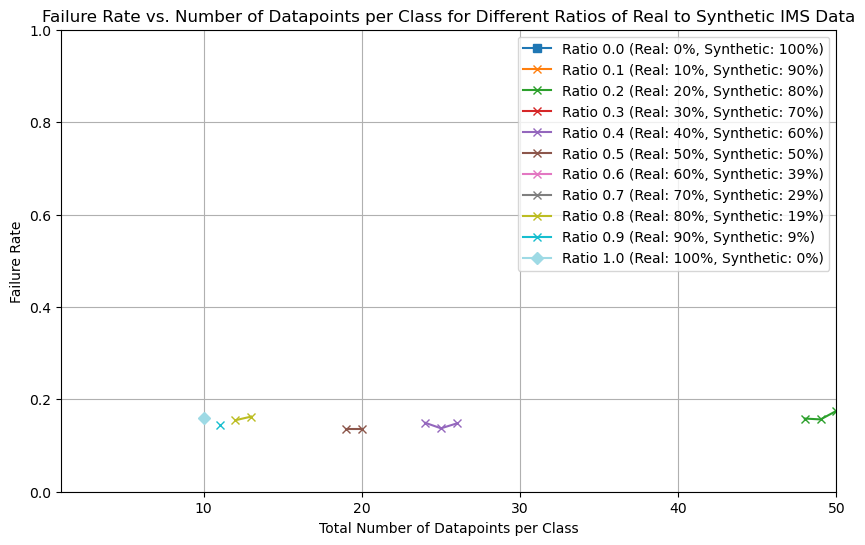

Overall Accuracy Data:
    Num Points  Failure Rate  Ratio
0           48      0.158375    0.2
1           49      0.156500    0.2
2           50      0.175000    0.2
3           24      0.149250    0.4
4           25      0.137250    0.4
5           26      0.147875    0.4
6           19      0.135500    0.5
7           20      0.135500    0.5
8           12      0.154750    0.8
9           13      0.162625    0.8
10          11      0.145500    0.9
11          10      0.160250    1.0


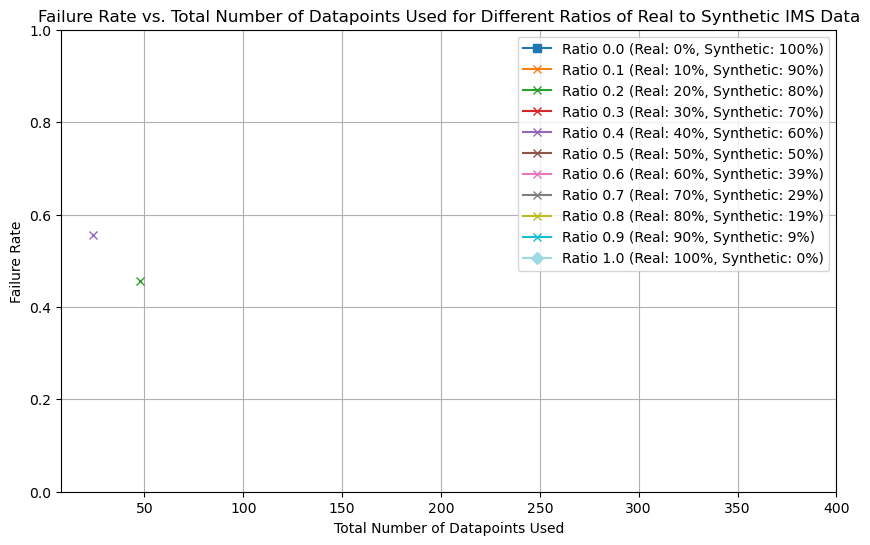

Datapoints Accuracy Data:
   Num Datapoints  Failure Rate  Ratio
0              48       0.45675    0.2
1              24       0.55650    0.4


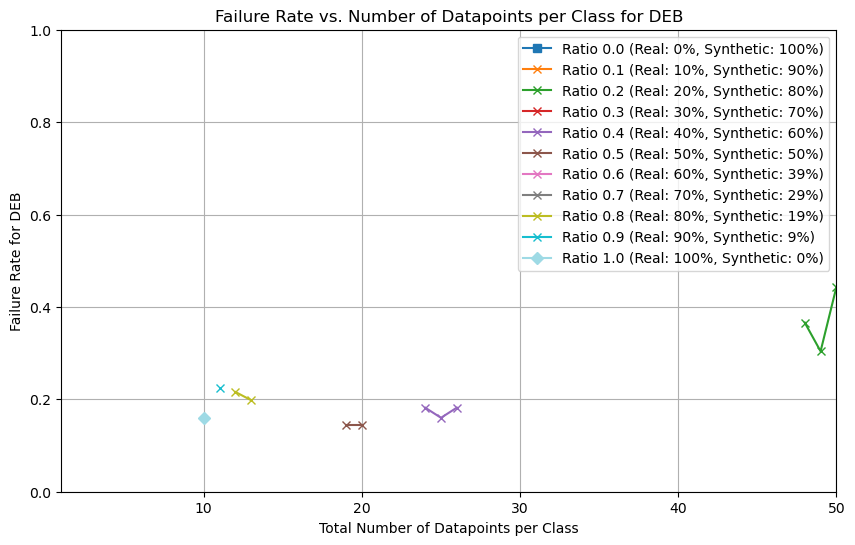

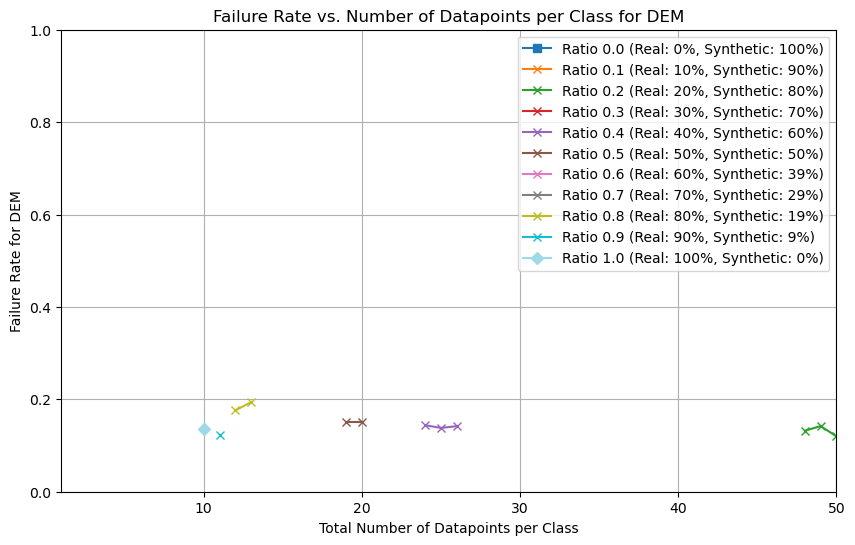

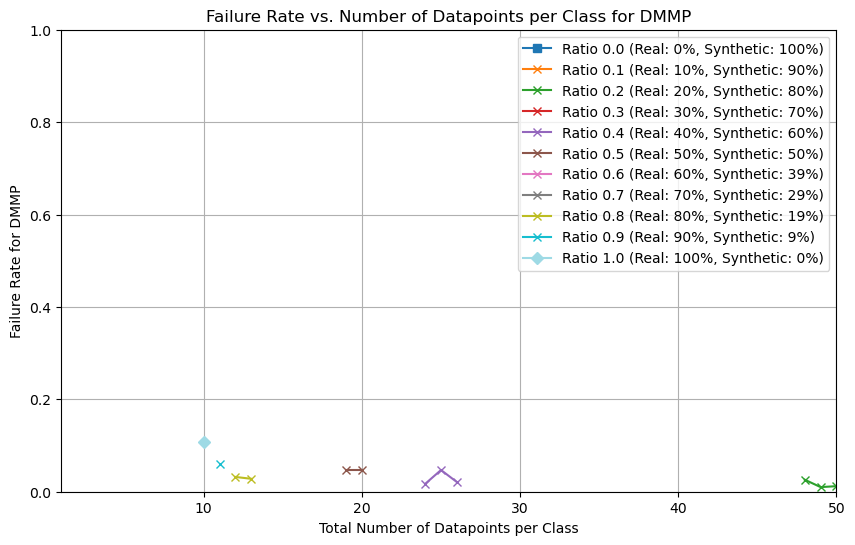

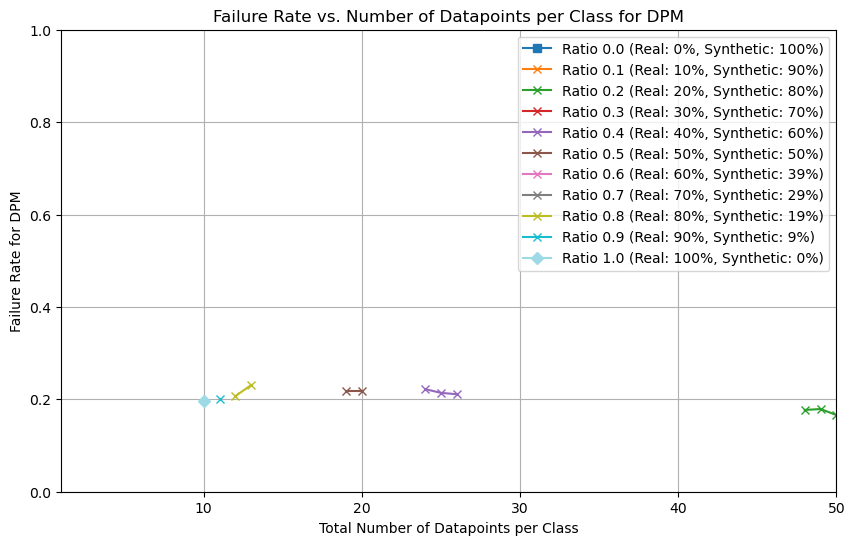

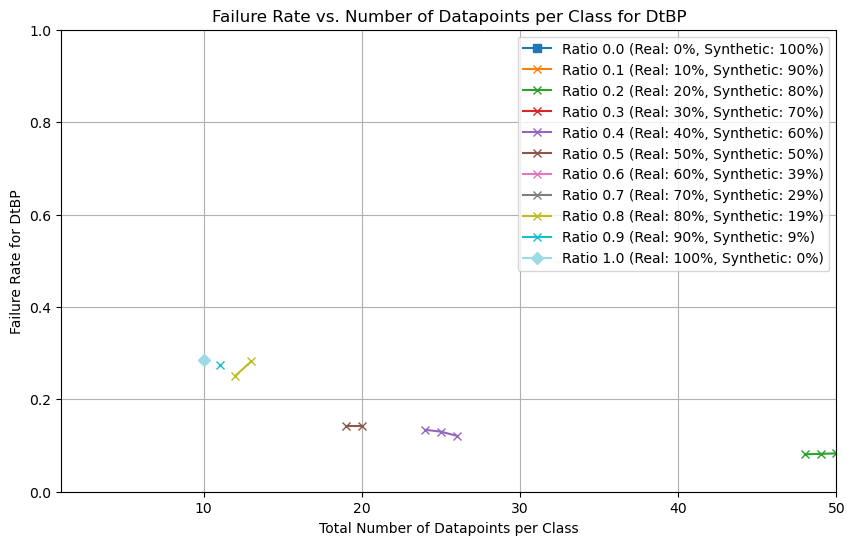

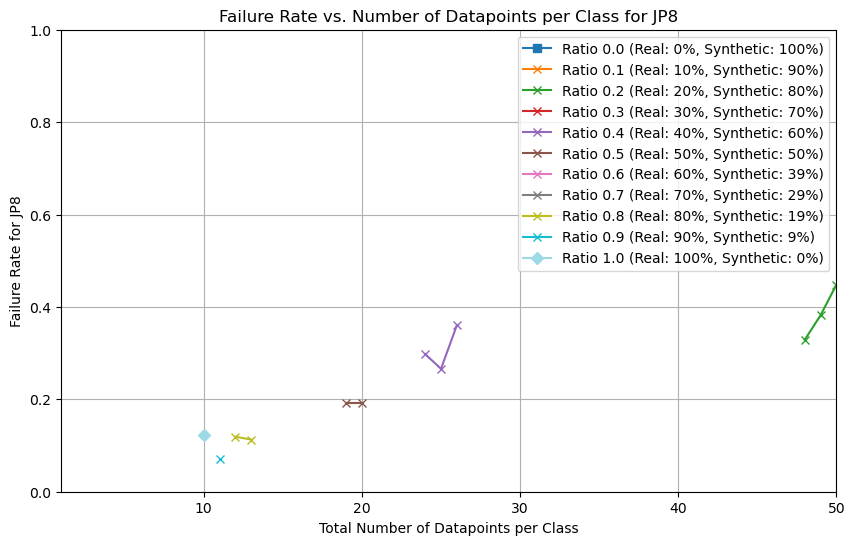

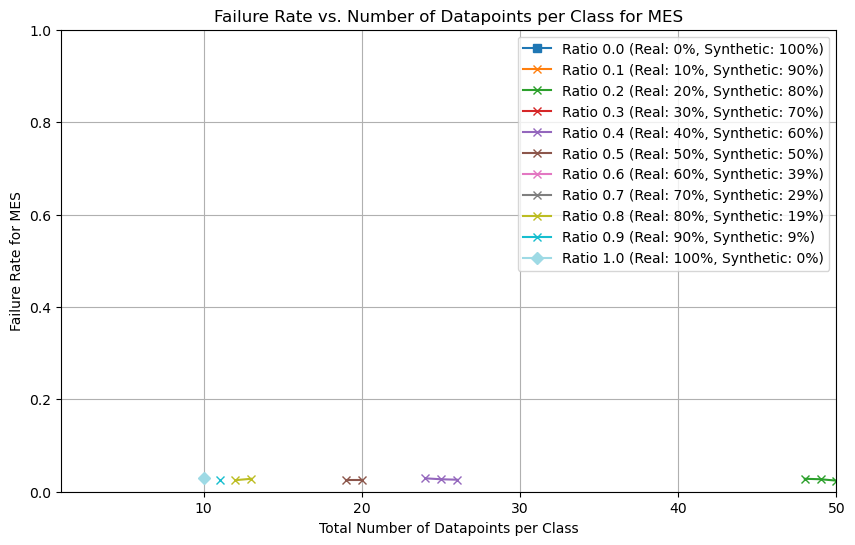

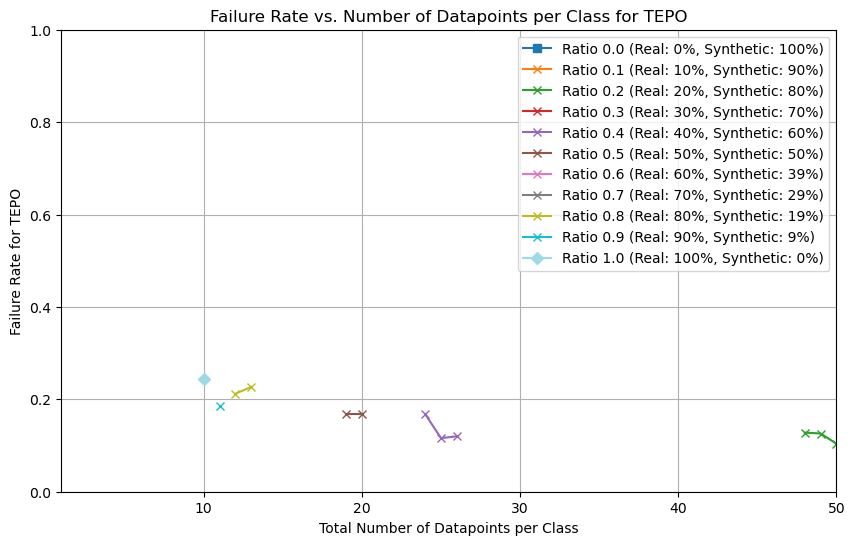

Class-wise Accuracy Data:
    Num Points  Failure Rate  Ratio Class
0           48         0.366    0.2   DEB
1           49         0.304    0.2   DEB
2           50         0.443    0.2   DEB
3           24         0.182    0.4   DEB
4           25         0.160    0.4   DEB
5           26         0.182    0.4   DEB
6           19         0.144    0.5   DEB
7           20         0.144    0.5   DEB
8           12         0.216    0.8   DEB
9           13         0.198    0.8   DEB
10          11         0.225    0.9   DEB
11          10         0.160    1.0   DEB
12          48         0.132    0.2   DEM
13          49         0.142    0.2   DEM
14          50         0.120    0.2   DEM
15          24         0.144    0.4   DEM
16          25         0.138    0.4   DEM
17          26         0.142    0.4   DEM
18          19         0.150    0.5   DEM
19          20         0.150    0.5   DEM
20          12         0.176    0.8   DEM
21          13         0.194    0.8   DEM
22      

In [26]:
import pandas as pd

# Define the specific points to plot
specific_points = {
    1.0: [10],
    0.9: [11],
    0.8: [12, 13],
    0.7: [14],
    0.6: [16, 17],
    0.5: [19, 20],
    0.4: [24, 25, 26],
    0.3: [32, 33, 34],
    0.2: [48, 49, 50]
}

# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
overall_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_points)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    overall_data.append(pd.DataFrame({
        'Num Points': np.array(num_points)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Number of Datapoints per Class for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_points), max(num_points))
plt.ylim(0, 1)
plt.show()

# Combine overall data into a single DataFrame and display
overall_df = pd.concat(overall_data, ignore_index=True)
print("Overall Accuracy Data:")
print(overall_df)

plt.figure(figsize=(10, 6))
datapoints_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_datapoints)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    datapoints_data.append(pd.DataFrame({
        'Num Datapoints': np.array(num_datapoints)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_datapoints), max(num_datapoints))
plt.ylim(0, 1)
plt.show()

# Combine datapoints data into a single DataFrame and display
datapoints_df = pd.concat(datapoints_data, ignore_index=True)
print("Datapoints Accuracy Data:")
print(datapoints_df)

# Plot class-wise accuracies
class_data = []

for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        specific_mask = np.isin(np.array([result[0] for result in class_results[class_label]])[mask], specific_points.get(ratio, []))
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask][specific_mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
        class_data.append(pd.DataFrame({
            'Num Points': np.array([result[0] for result in class_results[class_label]])[mask][specific_mask],
            'Failure Rate': 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask],
            'Ratio': ratio,
            'Class': label_list[class_label]
        }))
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}')
    plt.legend()
    plt.grid(True)
    plt.xlim(min(num_points), max(num_points))
    plt.ylim(0, 1)
    plt.show()

# Combine class data into a single DataFrame and display
class_df = pd.concat(class_data, ignore_index=True)
print("Class-wise Accuracy Data:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(class_df)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Function to train and evaluate the MLP classifier
def train_and_evaluate_mlp(X_train, y_train, X_test, y_test):
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

# Function to run the tests with different numbers of datapoints per class and ratios of real to synthetic data
def run_tests(real_data, synthetic_data, test_data, num_points_per_class, ratios):
    
    X_real, y_real = real_data.iloc[:, :-label_size].values, np.argmax(real_data.iloc[:, -label_size:].values, axis=1)
    X_synthetic, y_synthetic = synthetic_data.iloc[:, :-label_size].values, np.argmax(synthetic_data.iloc[:, -label_size:].values, axis=1)
    X_test, y_test = test_data.iloc[:, :-label_size].values, np.argmax(test_data.iloc[:, -label_size:].values, axis=1)
    
    results = []
    class_results = {class_label: [] for class_label in range(len(np.unique(y_test)))}
    
    for ratio in ratios:
        for num_points in num_points_per_class:
            X_train = []
            y_train = []
            
            for class_label in np.unique(y_real):
                real_indices = np.where(y_real == class_label)[0][:int(num_points * ratio + 0.5)]
                synthetic_indices = np.where(y_synthetic == class_label)[0][:int(num_points * (1 - ratio) + 0.5)]
                
                if len(real_indices) > 0:
                    X_train.append(X_real[real_indices])
                    y_train.append(y_real[real_indices])
                if len(synthetic_indices) > 0:    
                    X_train.append(X_synthetic[synthetic_indices])
                    y_train.append(y_synthetic[synthetic_indices])
            
            if len(X_train) > 0 and len(y_train) > 0:
                X_train = np.vstack(X_train)
                y_train = np.hstack(y_train)
                
                accuracy, y_pred = train_and_evaluate_mlp(X_train, y_train, X_test, y_test)
                results.append((num_points, ratio, accuracy, len(X_train)))
                
                class_accuracies = class_wise_accuracy(y_test, y_pred, len(np.unique(y_test)))
                for class_label in range(len(np.unique(y_test))):
                    class_results[class_label].append((num_points, ratio, class_accuracies[class_label]))
    
    return results, class_results

# Function to calculate class-wise accuracy
def class_wise_accuracy(y_true, y_pred, num_classes):
    accuracies = []
    for class_label in range(num_classes):
        class_indices = np.where(y_true == class_label)[0]
        class_accuracy = accuracy_score(y_true[class_indices], y_pred[class_indices])
        accuracies.append(class_accuracy)
    return accuracies

# Define the number of datapoints per class to test and the ratios of real to synthetic data
num_points_per_class = np.arange(1, 51)  # 1 to 50
ratios = np.linspace(0, 1, 11)  # Ratios from 0 to 1 in steps of 0.1

# Run the tests
label_size = 8  # Assuming there are 8 label columns at the end of the dataframe
results, class_results = run_tests(train, train_data, testing, num_points_per_class, ratios)

# Extract the results
num_points, ratios, accuracies, num_datapoints = zip(*results)

# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate of Real and Synthetic IMS Data, MLP')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# Plot class-wise accuracies
for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}, MLP')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()


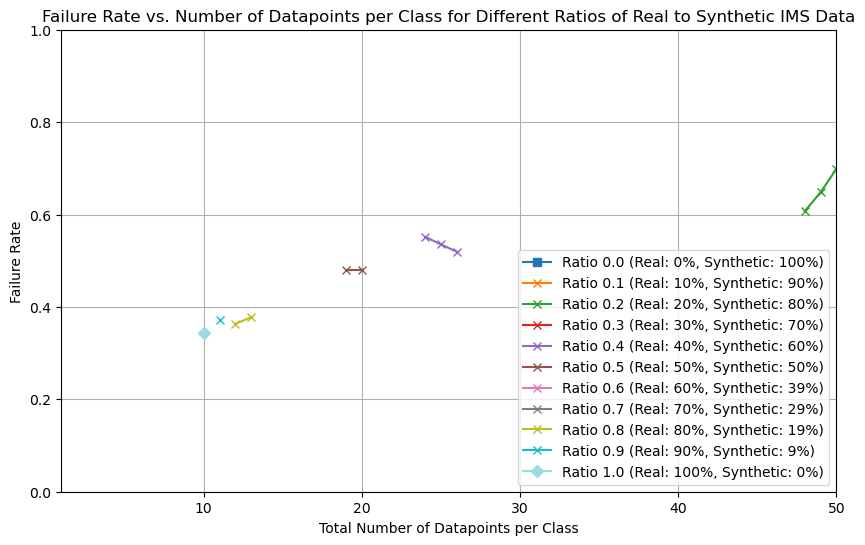

Overall Accuracy Data:
    Num Points  Failure Rate  Ratio
0           48      0.607250    0.2
1           49      0.648125    0.2
2           50      0.698750    0.2
3           24      0.551750    0.4
4           25      0.535250    0.4
5           26      0.519500    0.4
6           19      0.479500    0.5
7           20      0.479500    0.5
8           12      0.363375    0.8
9           13      0.377750    0.8
10          11      0.372625    0.9
11          10      0.343625    1.0


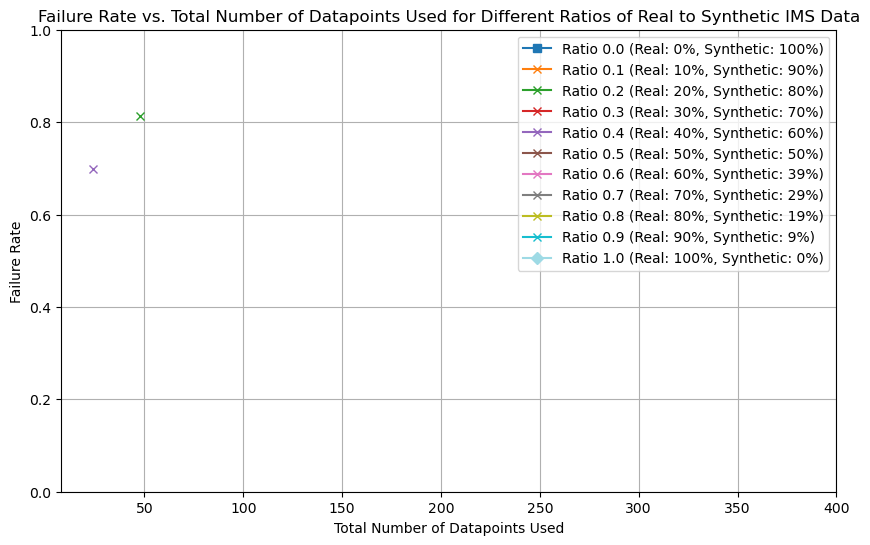

Datapoints Accuracy Data:
   Num Datapoints  Failure Rate  Ratio
0              48       0.81250    0.2
1              24       0.69775    0.4


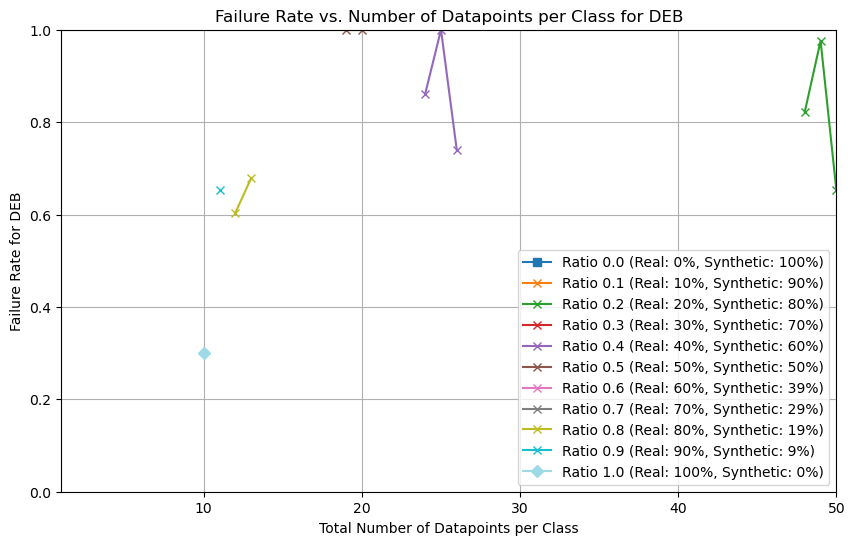

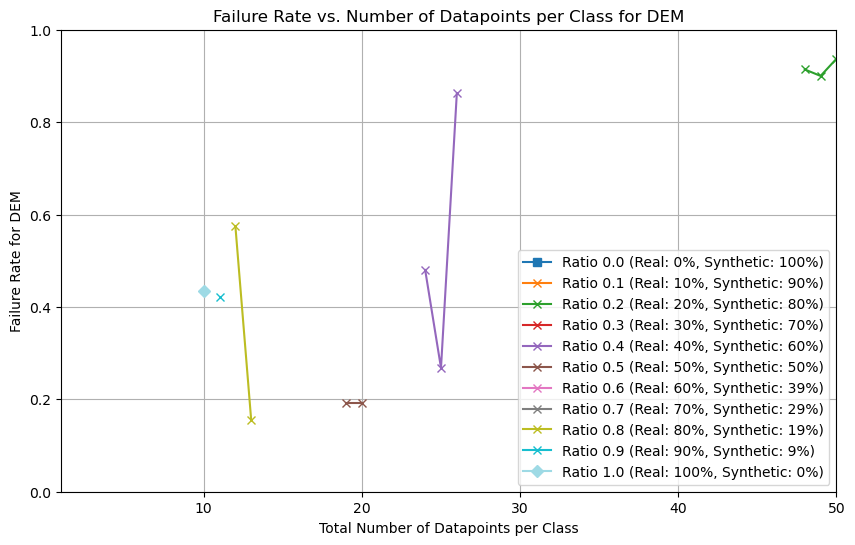

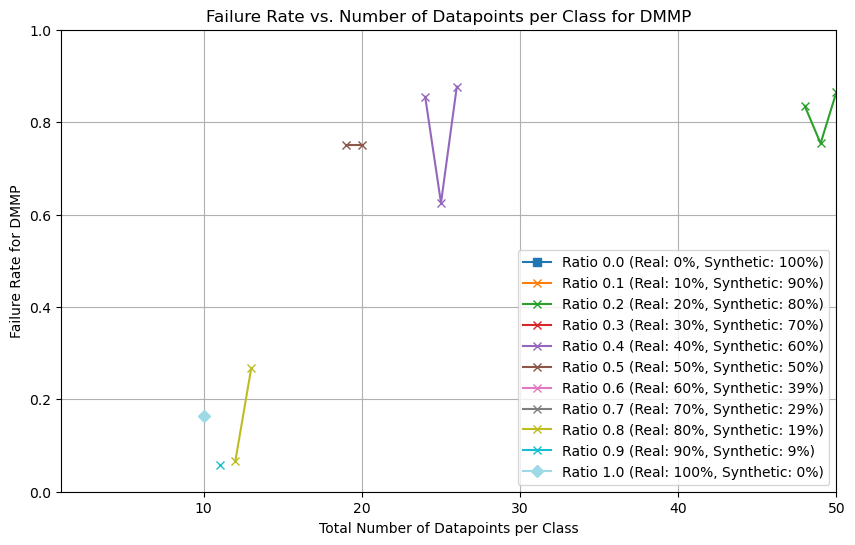

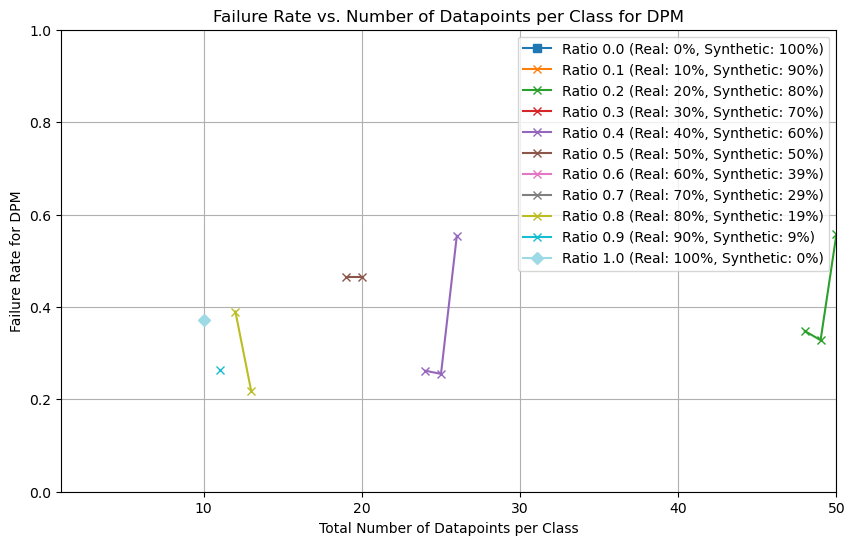

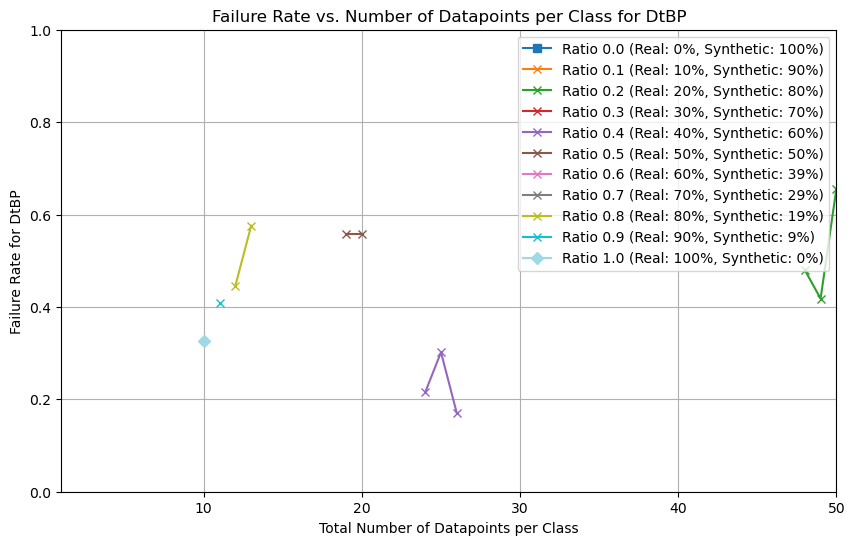

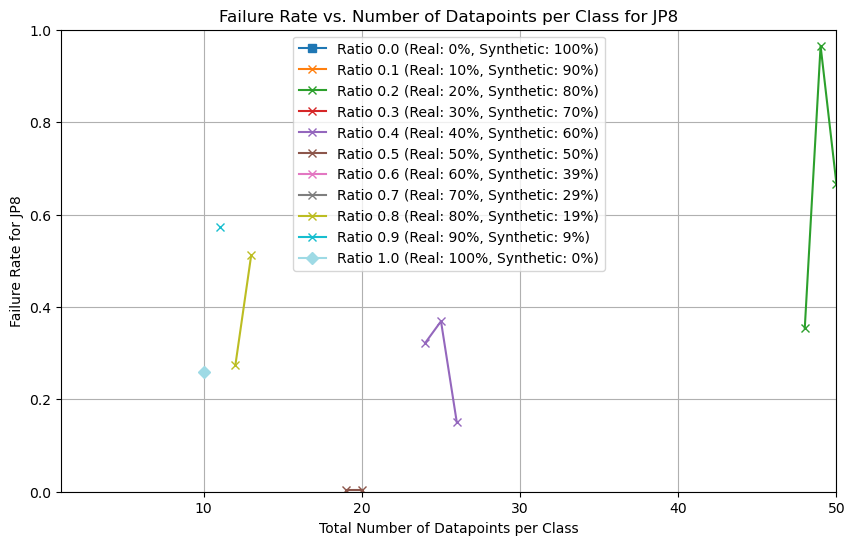

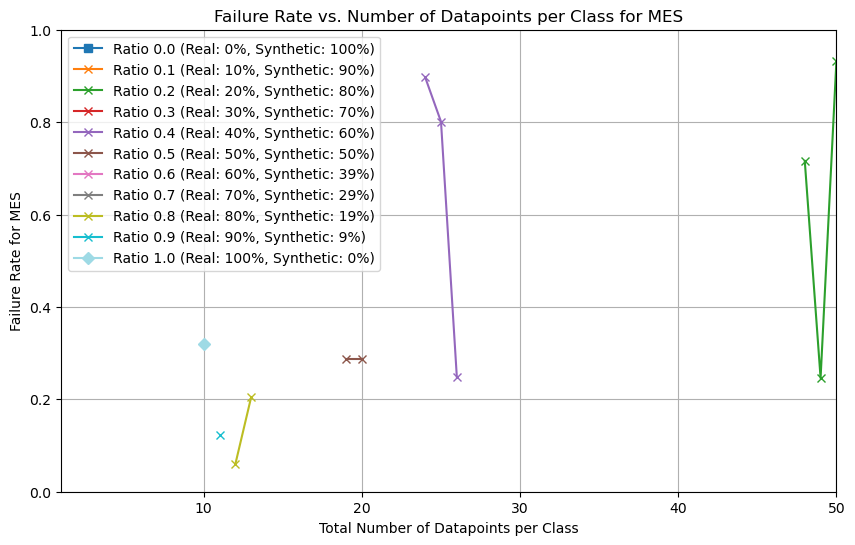

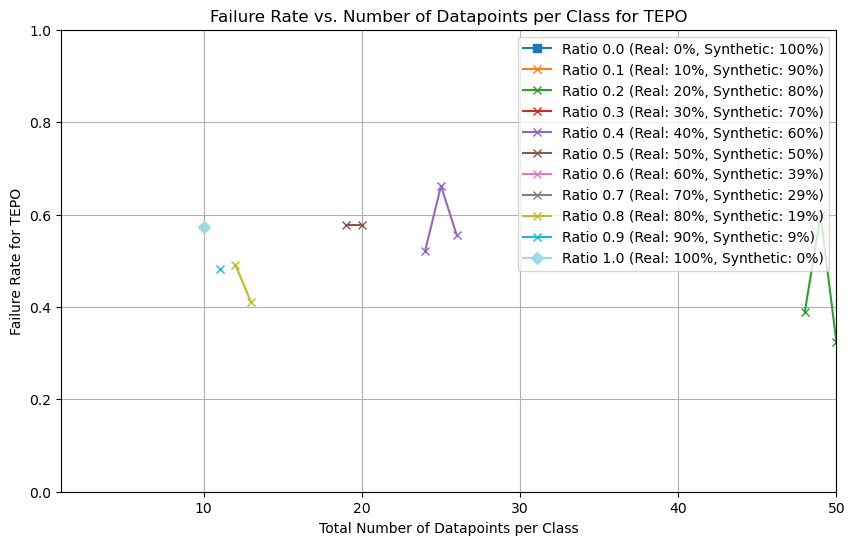

Class-wise Accuracy Data:
    Num Points  Failure Rate  Ratio Class
0           48         0.822    0.2   DEB
1           49         0.976    0.2   DEB
2           50         0.652    0.2   DEB
3           24         0.861    0.4   DEB
4           25         1.000    0.4   DEB
5           26         0.739    0.4   DEB
6           19         1.000    0.5   DEB
7           20         1.000    0.5   DEB
8           12         0.604    0.8   DEB
9           13         0.679    0.8   DEB
10          11         0.652    0.9   DEB
11          10         0.300    1.0   DEB
12          48         0.914    0.2   DEM
13          49         0.900    0.2   DEM
14          50         0.937    0.2   DEM
15          24         0.480    0.4   DEM
16          25         0.268    0.4   DEM
17          26         0.862    0.4   DEM
18          19         0.193    0.5   DEM
19          20         0.193    0.5   DEM
20          12         0.575    0.8   DEM
21          13         0.155    0.8   DEM
22      

In [ ]:
import pandas as pd

# Define the specific points to plot
specific_points = {
    1.0: [10],
    0.9: [11],
    0.8: [12, 13],
    0.7: [14],
    0.6: [16, 17],
    0.5: [19, 20],
    0.4: [24, 25, 26],
    0.3: [32, 33, 34],
    0.2: [48, 49, 50]
}

# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
overall_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_points)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    overall_data.append(pd.DataFrame({
        'Num Points': np.array(num_points)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Number of Datapoints per Class for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_points), max(num_points))
plt.ylim(0, 1)
plt.show()

# Combine overall data into a single DataFrame and display
overall_df = pd.concat(overall_data, ignore_index=True)
print("Overall Accuracy Data:")
print(overall_df)

plt.figure(figsize=(10, 6))
datapoints_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_datapoints)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    datapoints_data.append(pd.DataFrame({
        'Num Datapoints': np.array(num_datapoints)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_datapoints), max(num_datapoints))
plt.ylim(0, 1)
plt.show()

# Combine datapoints data into a single DataFrame and display
datapoints_df = pd.concat(datapoints_data, ignore_index=True)
print("Datapoints Accuracy Data:")
print(datapoints_df)

# Plot class-wise accuracies
class_data = []

for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        specific_mask = np.isin(np.array([result[0] for result in class_results[class_label]])[mask], specific_points.get(ratio, []))
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask][specific_mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
        class_data.append(pd.DataFrame({
            'Num Points': np.array([result[0] for result in class_results[class_label]])[mask][specific_mask],
            'Failure Rate': 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask],
            'Ratio': ratio,
            'Class': label_list[class_label]
        }))
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}')
    plt.legend()
    plt.grid(True)
    plt.xlim(min(num_points), max(num_points))
    plt.ylim(0, 1)
    plt.show()

# Combine class data into a single DataFrame and display
class_df = pd.concat(class_data, ignore_index=True)
print("Class-wise Accuracy Data:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(class_df)


In [ ]:
from itertools import product

# Function to run the tests with varying ratios per class
def run_tests_varying_ratios(real_data, synthetic_data, test_data, num_points_per_class, class_ratios):
    X_real, y_real = real_data.iloc[:, :-label_size].values, np.argmax(real_data.iloc[:, -label_size:].values, axis=1)
    X_synthetic, y_synthetic = synthetic_data.iloc[:, :-label_size].values, np.argmax(synthetic_data.iloc[:, -label_size:].values, axis=1)
    X_test, y_test = test_data.iloc[:, :-label_size].values, np.argmax(test_data.iloc[:, -label_size:].values, axis=1)
    
    results = []
    class_results = {class_label: [] for class_label in range(len(np.unique(y_test)))}
    
    for class_ratio in class_ratios:
        for num_points in num_points_per_class:
            X_train = []
            y_train = []
            
            for class_label, ratio in enumerate(class_ratio):
                real_indices = np.where(y_real == class_label)[0][:int(num_points * ratio + 0.5)]
                synthetic_indices = np.where(y_synthetic == class_label)[0][:int(num_points * (1 - ratio) + 0.5)]
                
                if len(real_indices) > 0:
                    X_train.append(X_real[real_indices])
                    y_train.append(y_real[real_indices])
                if len(synthetic_indices) > 0:    
                    X_train.append(X_synthetic[synthetic_indices])
                    y_train.append(y_synthetic[synthetic_indices])
            
            if len(X_train) > 0 and len(y_train) > 0:
                X_train = np.vstack(X_train)
                y_train = np.hstack(y_train)
                
                accuracy, y_pred = train_and_evaluate_mlp(X_train, y_train, X_test, y_test)
                results.append((num_points, class_ratio, accuracy, len(X_train)))
                
                class_accuracies = class_wise_accuracy(y_test, y_pred, len(np.unique(y_test)))
                for class_label in range(len(np.unique(y_test))):
                    class_results[class_label].append((num_points, class_ratio, class_accuracies[class_label]))
    
    return results, class_results

# Define the number of datapoints per class to test
num_points_per_class = np.arange(1, 51)  # 1 to 50

# Generate all combinations of ratios for each class (0, 0.5, 1)
class_ratios = list(product([0, 0.5, 1], repeat=label_size))

# Run the tests with varying ratios
results, class_results = run_tests_varying_ratios(train, train_data, testing, num_points_per_class, class_ratios)

# Extract the results
num_points, class_ratios, accuracies, num_datapoints = zip(*results)

# Visualize the results
plt.figure(figsize=(12, 8))
for i, class_ratio in enumerate(class_ratios):
    mask = np.array(class_ratios) == class_ratio
    plt.plot(np.array(num_points)[mask], 1 - np.array(accuracies)[mask], label=f'Class Ratios: {class_ratio}')
plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate for Varying Class Ratios, MLP')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize class-wise failure rates
for class_label in range(label_size):
    plt.figure(figsize=(12, 8))
    for i, class_ratio in enumerate(class_ratios):
        mask = np.array([result[1] for result in class_results[class_label]]) == class_ratio
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask], 
                 label=f'Class Ratios: {class_ratio}')
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}, MLP')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
print("Real training data", train)
print("Synthetic training data:", train_data)
print("Real Testing data", testing)

# Image of each spec along the way

In [ ]:
def plot_mass_spectra(label_idx, x_target_tensor, x_start_tensor, test_target_tensor, test_dataset_tensor, output, chem_names):
    """
    Plots five mass spectra side by side for a given label index with specific titles and axes scaling.
    
    Args:
        label_idx (int): The label index (0 to 49).
        x_target_tensor (torch.Tensor): Tensor containing target data with labels.
        x_start_tensor (torch.Tensor): Tensor containing diffused mass spectra.
        test_target_tensor (torch.Tensor): Tensor containing test target data with labels.
        test_dataset_tensor (torch.Tensor): Tensor containing test dataset data with labels.
        output (torch.Tensor): Tensor containing output predictions with labels.
        chem_names (pd.Series): Series of chemical names for labeling.
    """
    num_features = data_size  # Number of features (mass spectra columns)
    
    # Extract the first entry with the provided label from x_target_tensor
    x_target_label_mask = (x_target_tensor[:, -label_size + label_idx] == 1)
    x_target_first_idx = torch.where(x_target_label_mask)[0][0]
    x_target_spectrum = x_target_tensor[x_target_first_idx, :num_features].cpu().numpy()
    
    # Extract the corresponding mass spectrum from x_start_tensor
    x_start_spectrum = x_start_tensor[x_target_first_idx, :num_features].cpu().numpy()
    
    # Extract the first entry with the provided label from test_target_tensor
    test_target_label_mask = (test_target_tensor[:, -label_size + label_idx] == 1)
    test_target_first_idx = torch.where(test_target_label_mask)[0][0]
    test_target_spectrum = test_target_tensor[test_target_first_idx, :num_features].cpu().numpy()
    
    # Corresponding mass spec in the test_dataset_tensor
    test_dataset_spectrum = test_dataset_tensor[test_target_first_idx, :num_features].cpu().numpy()
    
    # Corresponding mass spec in the output
    output_spectrum = output[test_target_first_idx, :num_features].cpu().detach().numpy()
    
    # Chemical name for the label
    chem_name = chem_names[label_idx] if label_idx < len(chem_names) else f"Label {label_idx}"
    
    # Plot the graphs side by side
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()
    
    axes[0].plot(x_target_spectrum, label=f'{chem_name}', color='black')
    axes[0].set_title(f'Original IMS for {chem_name}')
    axes[0].set_xlabel('Mass to Charge Ratio')
    axes[0].set_ylabel('Intensity')
    #axes[0].set_xlim(0, 914)
    axes[0].set_ylim(0, 100)
    
    axes[1].plot(x_start_spectrum, label=f'{chem_name}', color='black')
    axes[1].set_title(f'Diffused IMS for {chem_name}')
    axes[1].set_xlabel('Mass to Charge Ratio')
    #axes[1].set_xlim(0, 914)
    axes[1].set_ylim(0, 100)
    
    axes[2].plot(test_dataset_spectrum, label=f'{chem_name}', color='red')
    axes[2].set_title(f'Diffused Convex Combination for {chem_name}')
    axes[2].set_xlabel('Mass to Charge Ratio')
    #axes[2].set_xlim(0, 914)
    axes[2].set_ylim(0, 100)
    
    axes[3].plot(test_target_spectrum, label=f'{chem_name}', color='blue')
    axes[3].set_title(f'Convex Combination for {chem_name}')
    axes[3].set_xlabel('Mass to Charge Ratio')
    #axes[3].set_xlim(0, 100)
    axes[3].set_ylim(0, 100)
    
    axes[4].plot(output_spectrum, label=f'{chem_name}', color='purple')
    axes[4].set_title(f'Real-Life-Like Synthetic Spectrum for {chem_name}')
    axes[4].set_xlabel('Mass to Charge Ratio')
    #axes[4].set_xlim(0, 100)
    axes[4].set_ylim(0, 100)
    
    # Remove the unused last plot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()

# Example usage:
chem_names=one_hot_labels
plot_mass_spectra(0, x_target_tensor, x_start_tensor, test_target_tensor, test_dataset_tensor, output, chem_names)


In [ ]:
print(one_hot_labels)

In [ ]:
def plot_mass_spectra_with_noise_and_network(label_idx, x_target_tensor, chem_INN, add_noise):
    """
    Plots and processes mass spectra with noise and network mapping.
    
    Args:
        label_idx (int): The label index (0 to 49).
        x_target_tensor (torch.Tensor): Tensor containing target data with labels.
        chem_INN (torch.nn.Module): Neural network model for chemical data processing.
        add_noise (callable): Function to add noise to a spectrum.
    """
    num_features = data_size  # Number of mass spectra columns

    # Extract the first and second entries with the provided label
    label_mask = (x_target_tensor[:, -label_size + label_idx] == 1)
    label_indices = torch.where(label_mask)[0][:2]

    if len(label_indices) < 2:
        raise ValueError("Not enough instances of the label to perform the required operations.")

    spectrum1 = x_target_tensor[label_indices[0], :].cpu()
    spectrum2 = x_target_tensor[label_indices[1], :].cpu()
    
    max_entry = torch.max(spectrum1)
    if max_entry > 0:  # Avoid division by zero
        scaled_spectrum1 = (spectrum1 / max_entry) * 100

    max_entry = torch.max(spectrum2)
    if max_entry > 0:  # Avoid division by zero
        scaled_spectrum2 = (spectrum2 / max_entry) * 100
    
    # Add noise to the entire spectrum (including last 50 dimensions)
    spectrum1_df = pd.DataFrame(spectrum1.clone().unsqueeze(0).numpy())
    spectrum2_df = pd.DataFrame(spectrum2.clone().unsqueeze(0).numpy())

    noisy_spectrum1_df = add_noise(spectrum1_df, 1)
    noisy_spectrum2_df = add_noise(spectrum2_df, 1)

    # Convert noisy spectra back to tensors
    noisy_spectrum1 = torch.tensor(noisy_spectrum1_df.values).squeeze(0)
    noisy_spectrum2 = torch.tensor(noisy_spectrum2_df.values).squeeze(0)
    
    max_entry = torch.max(noisy_spectrum1)
    if max_entry > 0:  # Avoid division by zero
        scaled_noisy_spectrum1 = (noisy_spectrum1 / max_entry) * 100

    max_entry = torch.max(noisy_spectrum2)
    if max_entry > 0:  # Avoid division by zero
        scaled_noisy_spectrum2 = (noisy_spectrum2 / max_entry) * 100

    # Convex combinations (retain the last 50 dimensions)
    alpha = 0.5
    convex_original = alpha * spectrum1 + (1 - alpha) * spectrum2
    convex_noisy = alpha * noisy_spectrum1 + (1 - alpha) * noisy_spectrum2

    # Ensure convex combinations are on the same device and dtype as the model
    convex_original = convex_original.to(device).to(torch.float32)
    convex_noisy = convex_noisy.to(device).to(torch.float32)
    
    max_entry = torch.max(convex_original)
    if max_entry > 0:  # Avoid division by zero
        scaled_convex_original = (convex_original / max_entry) * 100

    max_entry = torch.max(convex_noisy)
    if max_entry > 0:  # Avoid division by zero
        scaled_convex_noisy = (convex_noisy / max_entry) * 100

    # Pass through the network 5 times
    chem_INN.eval()
    with torch.no_grad():
        # Initialize outputs on the correct device and dtype
        outputs_original = [convex_original.unsqueeze(0).to(device).to(torch.float32)]
        outputs_noisy = [convex_noisy.unsqueeze(0).to(device).to(torch.float32)]
        
        for _ in range(5):
            # Append network outputs to the respective lists
            outputs_original.append(chem_INN(outputs_original[-1]))
            outputs_noisy.append(chem_INN(outputs_noisy[-1]))

    # Normalize only the final outputs
    final_original = outputs_original[-1]
    max_entry = torch.max(final_original)
    if max_entry > 0:  # Avoid division by zero
        final_original = (final_original / max_entry) * 100

    final_noisy = outputs_noisy[-1]
    max_entry = torch.max(final_noisy)
    if max_entry > 0:  # Avoid division by zero
        final_noisy = (final_noisy / max_entry) * 100
    
    # Graphing
    fig, axes = plt.subplots(4, 2, figsize=(18, 15))
    axes = axes.flatten()

    # Original spectra
    axes[0].plot(scaled_spectrum1[:num_features].numpy(), label="Spectrum 1 (Original)", color="black")
    axes[0].set_title("Spectrum 1 for DEB ")
    axes[2].plot(scaled_spectrum2[:num_features].numpy(), label="Spectrum 2 (Original)", color="black")
    axes[2].set_title("Spectrum 2 for DEB ")

    # Noisy spectra
    axes[1].plot(scaled_noisy_spectrum1[:num_features].numpy(), label="Spectrum 1 (Noisy)", color="blue")
    axes[1].set_title("Diffused Spectrum 1 for DEB")
    axes[3].plot(scaled_noisy_spectrum2[:num_features].numpy(), label="Spectrum 2 (Noisy)", color="blue")
    axes[3].set_title("Diffused Spectrum 2 for DEB")

    # Convex combinations
    axes[4].plot(scaled_convex_original[:num_features].cpu().numpy(), label="Convex Combination (Original)", color="green")
    axes[4].set_title("Convex Combination of Spectra 1 and 2")
    axes[5].plot(scaled_convex_noisy[:num_features].cpu().numpy(), label="Convex Combination (Noisy)", color="green")
    axes[5].set_title("Convex Combination of Diffused Spectra 1 and 2")

    # Network outputs (final iteration)
    axes[6].plot(final_original[0, :num_features].cpu().numpy(), color="purple")
    axes[6].set_title("Convex Combination of Spectra 1 and 2 - After Chem_INN")
    axes[7].plot(final_noisy[0, :num_features].cpu().numpy(), color="purple")
    axes[7].set_title("Convex Combination Diffused of Spectra 1 and 2 - After Chem_INN")

    # Legend and axis scaling
    for ax in axes:
        ax.set_xlabel("Mass to Charge Ratio")
        ax.set_ylabel("Intensity")
        ax.set_ylim(0, 100)

    # Remove unused axes
    #fig.delaxes(axes[8])
    plt.tight_layout()
    plt.show()

plot_mass_spectra_with_noise_and_network(0, x_target_tensor, chem_INN, add_noise)


# Inverse

In [ ]:
# Set the dimensionality of the system.
n = x_size

# Calculate the effective weight matrix by combining the learned weights with the initial weights and hadamard multiplication by the mask.
weights = chem_MaskLin.U * chem_MaskLin.mask + chem_MaskLin.weight_0

# Extract the biases from the linear layer.
biases = chem_MaskLin.bias

# Perform Singular Value Decomposition (SVD) on the weight matrix.
# This decomposes the weight matrix into three matrices: U, S, and V,
# where U and V are orthogonal matrices, and S is a diagonal matrix of singular values.
U, S, V = torch.svd(weights)#-0.04*torch.eye(n))

# Initialize a zero matrix with the shape transposed from the weight matrix.
# This will be used to store the inverted singular values.
S_inv = torch.zeros_like(weights.T)

# Print the singular values to check their magnitudes.
# print(S)

# Iterate through each singular value.
for i in range(len(S)):
    # Invert the singular value if it is significantly large (avoids numerical instability for very small values).
    if S[i] > 1e-15:  # Threshold to avoid division by very small numbers, which can lead to instability.
        S_inv[i, i] = 1. / S[i]

# Compute the pseudo-inverse of the weight matrix by multiplying V, S_inv, and the transpose of U.
# This is based on the property of SVD that the pseudo-inverse of a matrix A is given by V * S_inv * U^T.
inv_weight = V.mm(S_inv).mm(U.t())

# Define the inverse Leaky ReLU function.
# This function reverses the Leaky ReLU activation by applying the inverse operation to both positive and negative inputs.
def LReLU_inv(x):
    return torch.where(x >= 0, x, 10 * x)

def PReLU_inv(x, i):
    prelu1 = chem_INN[1]
    alpha = prelu1.weight
    print(alpha)
    return torch.where(x>=0,x, x/alpha)
    
# Define the inverse function for the neural network.
# This function iteratively applies the pseudo-inverse transformation and the inverse Leaky ReLU to the input y.
# iters is necessarily the number of LeakyReLUs in the INN otherwise we'll be off.
def inv_INN(y,iters):
    for iter in range(iters):
        # Apply the inverse transformation: inverse Leaky ReLU followed by a linear transformation using the pseudo-inverse weights.
        y = torch.matmul(LReLU_inv(y)-biases, inv_weight)
    # After the specified number of iterations, apply the final transformation and return the result.
    return y # torch.matmul(y, inv_weight.T) - biases


## One Hot Encoding Inverse

In [ ]:
iters = num_relus
mapped_tensor = x_start_tensor
for i in range(iters):
    mapped_tensor = chem_INN(mapped_tensor).detach()

inv_tensor = inv_INN(mapped_tensor, num_relus).detach()

pred_last_50 = inv_tensor[:, -50:]  # Last 50 elements
target_last_50 = x_start_tensor[:,-50:]

# Flatten the predictions and targets to compare each element
pred_classes = torch.argmax(pred_last_50, dim=1).cpu().numpy().flatten()  # No reduction, just flatten
target_classes = torch.argmax(target_last_50, dim=1).cpu().numpy().flatten()

conf_matrix = confusion_matrix(target_classes, pred_classes, labels=np.arange(50))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Display the plot
plt.show()

## Mass Spectra Inverse

In [ ]:
iters = num_relus

mapped_tensor = x_start_tensor
for i in range(iters):
    mapped_tensor = chem_INN(mapped_tensor).detach()

inv_tensor = inv_INN(mapped_tensor, num_relus).detach()

# Get the first row for plotting
inverse_mass_spec = inv_tensor[0].cpu().numpy() 
original_mass_spec = x_start_tensor[0].cpu().numpy()

# Now plot
plt.figure(figsize=(10, 5))
plt.plot(inverse_mass_spec[0:915], label='Inverse Mass Spec', color='orange')  # Add label to the first plot
plt.plot(original_mass_spec[0:915], label='Original Mass Spec', color='blue')  # Add label to the second plot

plt.title('Inverse vs Original Mass Spec')  # Add a title
plt.xlabel('Mass to Charge Ratio')  # Add x-axis label
plt.ylabel('Intensity')  # Add y-axis label
plt.ylim(-100, 100)


plt.legend()  # Add the legend to show the labels
plt.show()